This notebook contains the comparison between the eulogies pre and post Revolution

# 1. Load and imports

In [1]:
from eda import *
from pre_process import *
from topic_modeling import *
from percent import *
from adverbs_eda import *
from itertools import chain
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel
from transformers import CamembertModel
from bertopic import BERTopic




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import plotly.express as px
import plotly.offline as pyo
import kaleido


pyo.init_notebook_mode()


/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/Documents/COURS_EPFL/MA4-2022/PDS/eloge_academie/Code/Comparison/eda.py:13: FutureWarning: The squeeze ar

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.max_columns', 200)

In [4]:
df = pd.read_csv('./../../Data/Dataframes/eulogies.csv')

In [5]:
#Keeping the eulogies that interest us
df = df[((df['Annee']>1793) & (df['Annee']<1832))|(df['Auteur'] =='Condorcet')]

# 2. First axis : basic statistics

## Removing \n, \t, non-useful spaces

In [6]:
#Removing encryption characters

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

In [7]:
df.head(1)

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## a. Number of eulogies

In [8]:
print('There are ' + str(df.shape[0]) + ' eulogies') 
print('There are ' + str(df[df['Annee']<1793].shape[0]) + ' eulogies before the French Revolution')
print('There are ' + str(df[df['Annee']>=1793].shape[0]) + ' eulogies after the French Revolution')

There are 144 eulogies
There are 79 eulogies before the French Revolution
There are 65 eulogies after the French Revolution


In [9]:
print('There are ' + str(df['Auteur'].nunique()) + ' different authors')
print('There is ' + str(df[df['Annee']<1793]['Auteur'].nunique()) + ' author before the Revolution')
print('There are ' + str(df[df['Annee']>=1793]['Auteur'].nunique()) + ' different authors after the Revolution')

There are 12 different authors
There is 1 author before the Revolution
There are 11 different authors after the Revolution


## b. Number of eulogies per year

Text(0, 0.5, 'Number of eulogies')

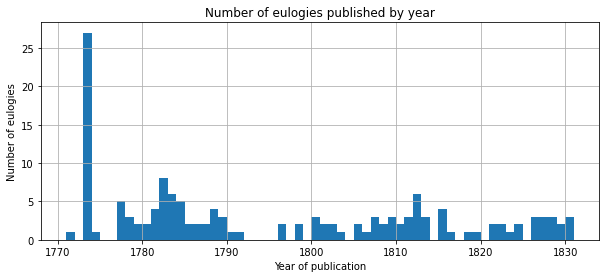

In [10]:
nbins = int(df['Annee'].max() - df['Annee'].min())
df.hist('Annee', bins = nbins, figsize = (10,4))
plt.title('Number of eulogies published by year')
plt.xlabel('Year of publication')
plt.ylabel('Number of eulogies')

In [11]:
df_help = df.groupby(['Annee'])['Savant'].count().reset_index().rename(columns = {'Savant' : 'count'})

df_pre = df_help[df_help['Annee']<=1793]
df_post = df_help[df_help['Annee']>1793]

In [12]:
#ttest indicating if the means are different
from scipy.stats import ttest_ind

ttest_ind(df_pre['count'].array, df_post['count'].array)

Ttest_indResult(statistic=1.8983552773467354, pvalue=0.06407384093561037)

## c. Length of the eulogies

In [13]:
#Removing the side information in the eulogies
side_info(df)

#Replacing the spelling of words
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('enfans', 'enfants').replace('instrumens', 'instruments')
                               .replace('talens', 'talents').replace('différens', 'différents').replace(
                               'monumens', 'monuments').replace('évènemens', 'évènements').replace('savans',
                                                                                                  'savants').
                               replace('documens', 'documents').replace('long-temps', 'longtemps'))

#Replacing encryption errors
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('†;', ';').replace('u?', 'ù').replace('¿', 'À')
                               .replace('∆', 'É').replace('∞', '°').replace('…', 'É').replace('¸','ü')
                               .replace('†:', ';').replace('†', ';'))

In [14]:
df['Weird'] = df['Eloge'].apply(lambda x : '  '.join(char for char in x if not char.isalnum()).split())

In [15]:
#Weird characters to check there are no encryption errors
df['Weird'].explode().value_counts()

,    51807
'    26205
’    22547
.    20809
;    8993 
-    4630 
:    2321 
?    459  
!    195  
(    189  
)    186  
"    117  
´    55   
*    53   
°    24   
\    18   
]    2    
¨    2    
‘    1    
«    1    
Name: Weird, dtype: int64

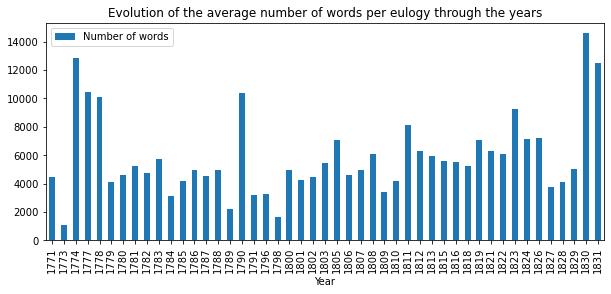

In [16]:
nbr_words_df = nbr_words(df, evol = True)

In [17]:
nbr_words_pre = nbr_words_df[nbr_words_df['Annee']<1793]
nbr_words_post = nbr_words_df[nbr_words_df['Annee']>=1793]

ttest_ind(nbr_words_pre['Number of words'].array, nbr_words_post['Number of words'].array)

Ttest_indResult(statistic=-0.4774190839407523, pvalue=0.6353744789224458)

## d. Average word length

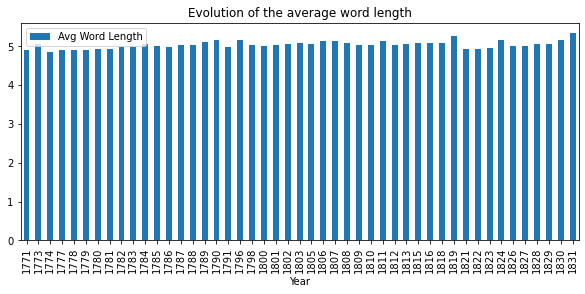

In [18]:
avg_words = avg_word_length(df, evol = True)

In [19]:
avg_words_pre = avg_words[avg_words['Annee']<=1793]
avg_words_post = avg_words[avg_words['Annee']>1793]

ttest_ind(avg_words_pre['Avg Word Length'].array, avg_words_post['Avg Word Length'].array)

Ttest_indResult(statistic=-3.742314319152467, pvalue=0.0005147496643131255)

## e. Average sentence length

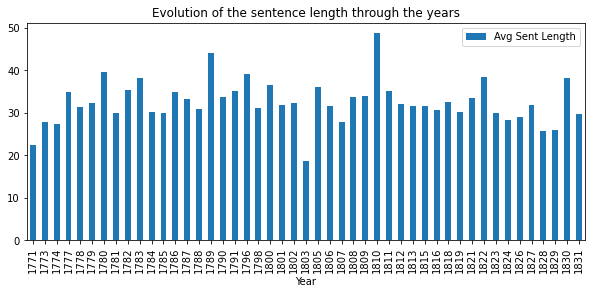

In [20]:
avg_sentence_df = avg_sentence(df, evol = True)

In [21]:
avg_sentence_pre = avg_sentence_df[avg_sentence_df['Annee']<1793]
avg_sentence_post = avg_sentence_df[avg_sentence_df['Annee']>=1793]

ttest_ind(avg_sentence_pre['Avg Sent Length'].array, avg_sentence_post['Avg Sent Length'].array)

Ttest_indResult(statistic=0.3813712628181362, pvalue=0.7047225879442865)

## f. Use of first person

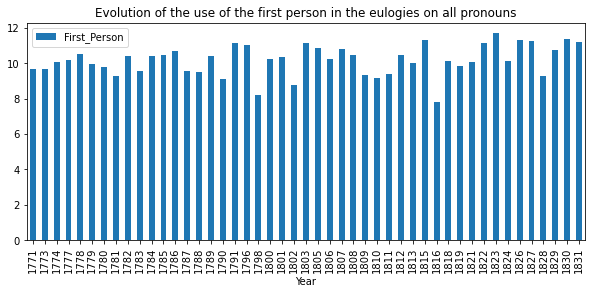

In [22]:
fst_person = first_person(df)

In [23]:
fst_person_pre = fst_person[fst_person['Annee']<1793]
fst_person_post = fst_person[fst_person['Annee']>=1793]

ttest_ind(fst_person_pre['First_Person'].array, fst_person_post['First_Person'].array)

Ttest_indResult(statistic=-0.9927395306841651, pvalue=0.3261452290734288)

## g. Use of imperative and conditionnal

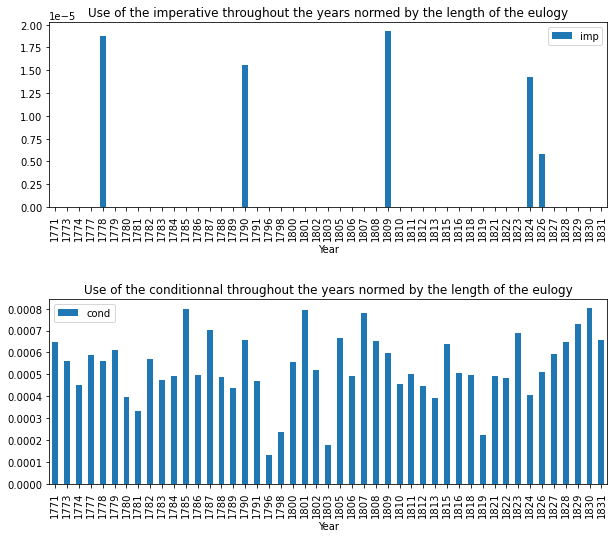

In [24]:
pci = cond_imperative(df)

## Dividing the eulogies by sentences

In [25]:
#Replacing M. by M for separation purposes
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))

sent = df.copy()

#Setting the separation character for sentences as '.'
sent['Eloge'] = sent['Eloge'].str.replace('!', '.')
sent['Eloge'] = sent['Eloge'].str.replace('?', '.')

#Dividing the sentences by '.'
sent['Eloge'] = sent['Eloge'].str.split('.')

# convert list of pd.Series then stack it
sent = (sent
 .set_index(['Savant','Auteur','Annee'])['Eloge']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_3', axis=1)
 .rename(columns={0:'Eloge'}))

#Removing sentences shorter than 10 characters and empty sentences
sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

sent.shape

(17784, 4)

## h. Use of adverbs

In [26]:
#Loading the adverbs dataset
df_ass = pd.read_csv('./../../Data/Results/ADV_BIG.csv')


#Dataframe with additionnal column containing solely the adverbs
adv = keep_adv(sent, 'Eloge')

#Adding columns that contains adverb that are in two different categoris
df_ass['Temp_Ass'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Temp_Exp'] = df_ass.apply(lambda row : 1 if ((row['Expérience']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Ass_Exp'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                 (row['Expérience']!='default value')) else 0,axis=1)


df_ass.head()

Adverb  Number_x      Categorie    Assertivité    Temporalité  \
0  -ci         74        default value  default value  default value   
1  -ci ne      5         default value  default value  default value   
2  absolument  54        affirmation    certain        default value   
3  ailleurs    91        lieu           default value  default value   
4  ainsi       564       logique        default value  default value   

      Expérience    Description  Temp_Ass  Temp_Exp  Ass_Exp  
0  default value  default value  0         0         0        
1  default value  default value  0         0         0        
2  default value  default value  0         0         0        
3  default value  default value  0         0         0        
4  default value  default value  0         0         0

In [27]:
#Making lists containing all the adverbs in each category

ls_ass = df_ass[(df_ass['Assertivité']!='default value') & (df_ass['Temp_Ass']==0) &
                                                         (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp = df_ass[(df_ass['Temporalité']!='default value') & (df_ass['Temp_Ass']==0)
                & (df_ass['Temp_Exp']==0)]['Adverb'].tolist()
ls_exp = df_ass[(df_ass['Expérience']!='default value') & (df_ass['Temp_Exp']==0)
               & (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp_exp = df_ass[df_ass['Temp_Exp']==1]['Adverb'].tolist()
ls_ass_exp = df_ass[df_ass['Ass_Exp']==1]['Adverb'].tolist()
ls_temp_ass = df_ass[df_ass['Temp_Ass']==1]['Adverb'].tolist()
ls_desc = df_ass[df_ass['Description']=='description']['Adverb'].tolist()

In [28]:
#Creating a dataframe with one column for each category of adverb that list the adverbs of this category present in
#the sentence
plot_adv = adv.copy()
plot_adv = plot_adv[['Savant', 'Auteur', 'Annee', 'Eloge', 'adverbs']]
plot_adv['Assertivité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass]))
plot_adv['Temporalité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp]))
plot_adv['Expérience'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_exp]))
plot_adv['Temp_Ass'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_ass]))
plot_adv['Temp_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_exp]))
plot_adv['Ass_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass_exp]))
plot_adv['Description'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_desc]))
plot_adv['Else'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if (elem not in ls_ass
                                                                                   and elem not in ls_temp
                                                                                   and elem not in ls_exp
                                                                                   and elem not in ls_ass
                                                                                   and elem not in ls_temp_ass
                                                                                   and elem not in ls_ass_exp
                                                                                   and elem not in ls_temp_exp
                                                                                   and elem not in ls_desc)]))

<AxesSubplot:title={'center':'Evolution of the use of all categories of adverbs through the years'}, xlabel='Year'>

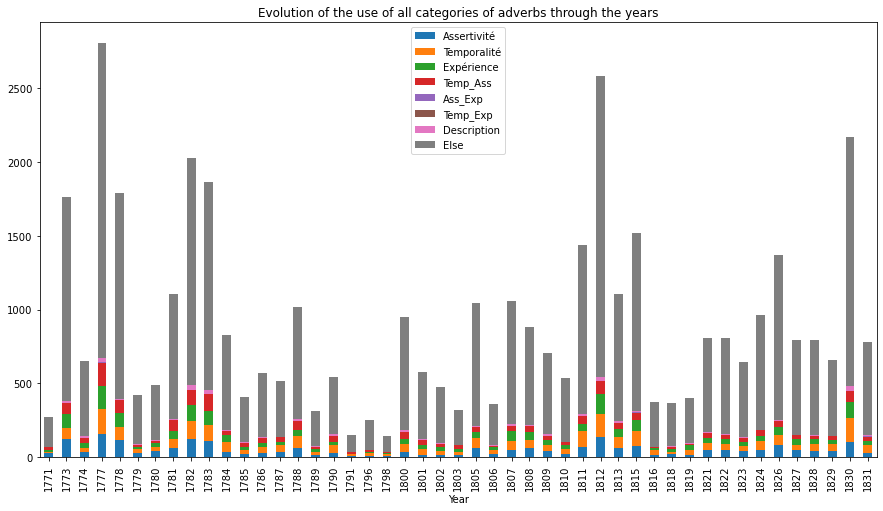

In [29]:
plot_adv_1 = plot_adv.groupby(['Annee']).agg({'Assertivité' : 'sum', 'Temporalité' : 'sum', 'Expérience' :
                                           'sum', 'Temp_Ass' : 'sum', 'Ass_Exp' : 'sum', 'Temp_Exp' : 'sum',
                                           'Description' : 'sum', 'Else' : 'sum'})

plot_adv_1.plot.bar(stacked = True, figsize = (15,8), xlabel='Year',
                    title='Evolution of the use of all categories of adverbs through the years')

In [30]:
plot_adv['Catégorie'] = plot_adv['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()
                                                             ['Categorie'][0]  
                                                             if elem in df_ass.Adverb.tolist() else 'Not Frequent'
                                                             for elem in x])


new_df = (
    plot_adv.explode('Catégorie')  # Explode List into Rows
        .groupby(['Annee','Catégorie']).size()  # Calculate Group Sizes
        .unstack(fill_value=0)  # Convert Category values to column names 
        .reset_index().rename_axis(columns=None)  # Cleanup
)

new_df.set_index('Annee', inplace = True)

<AxesSubplot:title={'center':'Evolution of the use of each kind of adverb throughout the years'}, xlabel='Year'>

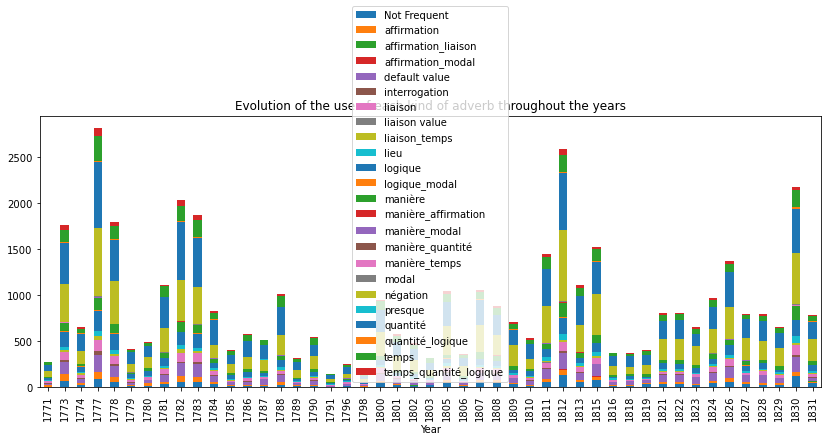

In [31]:
new_df.plot.bar( stacked=True, figsize = (14,5), title = 
                'Evolution of the use of each kind of adverb throughout the years', xlabel='Year')

<AxesSubplot:title={'center':'Evolution of the use of first half of categories of adverb throughout the years'}, xlabel='Year'>

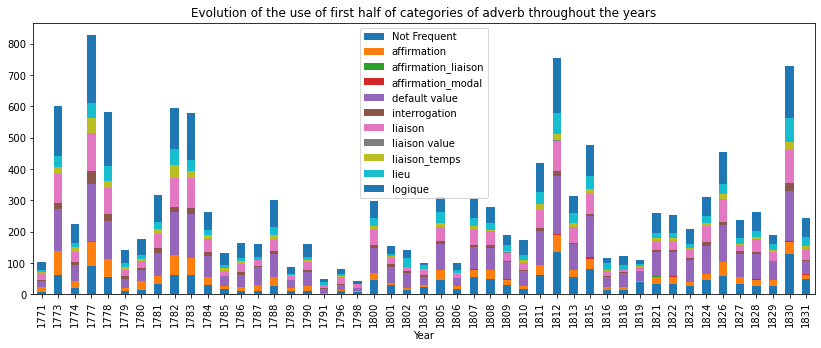

In [32]:
#Separating previous graph in two for better visualization
new_df.iloc[:,:11].plot.bar( stacked=True, figsize = (14,5), title = 
                'Evolution of the use of first half of categories of adverb throughout the years', xlabel='Year')

<AxesSubplot:title={'center':'Evolution of the use of second half of categories of adverb throughout the years'}, xlabel='Year'>

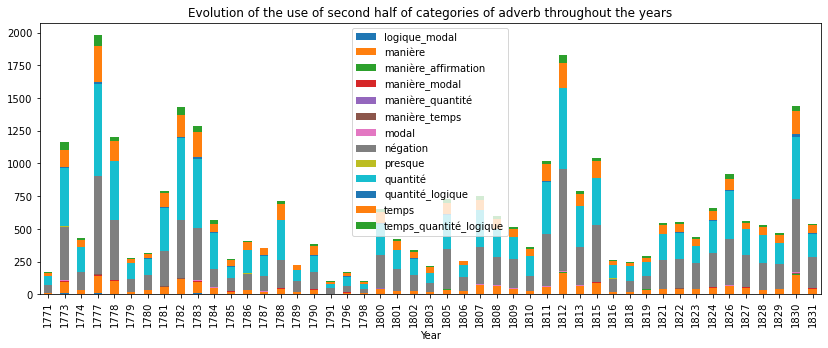

In [33]:
new_df.iloc[:,11:].plot.bar( stacked=True, figsize = (14,5), title = 
                'Evolution of the use of second half of categories of adverb throughout the years', xlabel='Year')

<AxesSubplot:title={'center':'Evolution of the use of categories of adverbs normed by the number of adverbs used each year'}, xlabel='Year'>

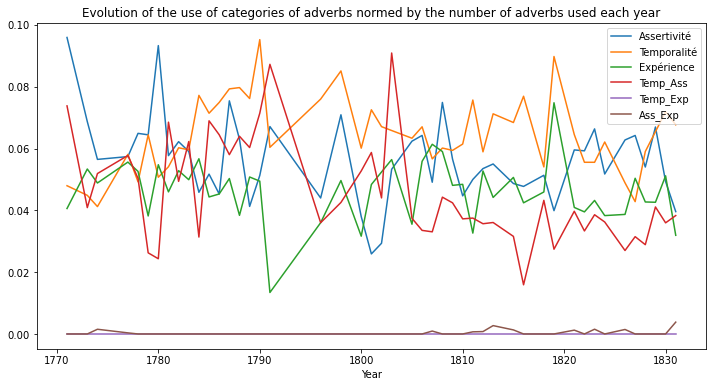

In [34]:
plot_adv_1['All'] = plot_adv_1.sum(axis=1)
plot_adv_1['Assertivité'] = plot_adv_1.apply(lambda row : row['Assertivité']/row['All'],axis=1)
plot_adv_1['Temporalité'] = plot_adv_1.apply(lambda row : row['Temporalité']/row['All'],axis=1)
plot_adv_1['Expérience'] = plot_adv_1.apply(lambda row : row['Expérience']/row['All'],axis=1)
plot_adv_1['Temp_Ass'] = plot_adv_1.apply(lambda row : row['Temp_Ass']/row['All'],axis=1)
plot_adv_1['Temp_Exp'] = plot_adv_1.apply(lambda row : row['Temp_Exp']/row['All'],axis=1)
plot_adv_1['Ass_Exp'] = plot_adv_1.apply(lambda row : row['Ass_Exp']/row['All'],axis=1)

plot_adv_1[['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp']].plot(kind='line',
                                                                                              figsize = (12,6),
            title='Evolution of the use of categories of adverbs normed by the number of adverbs used each year',
                                    xlabel='Year')

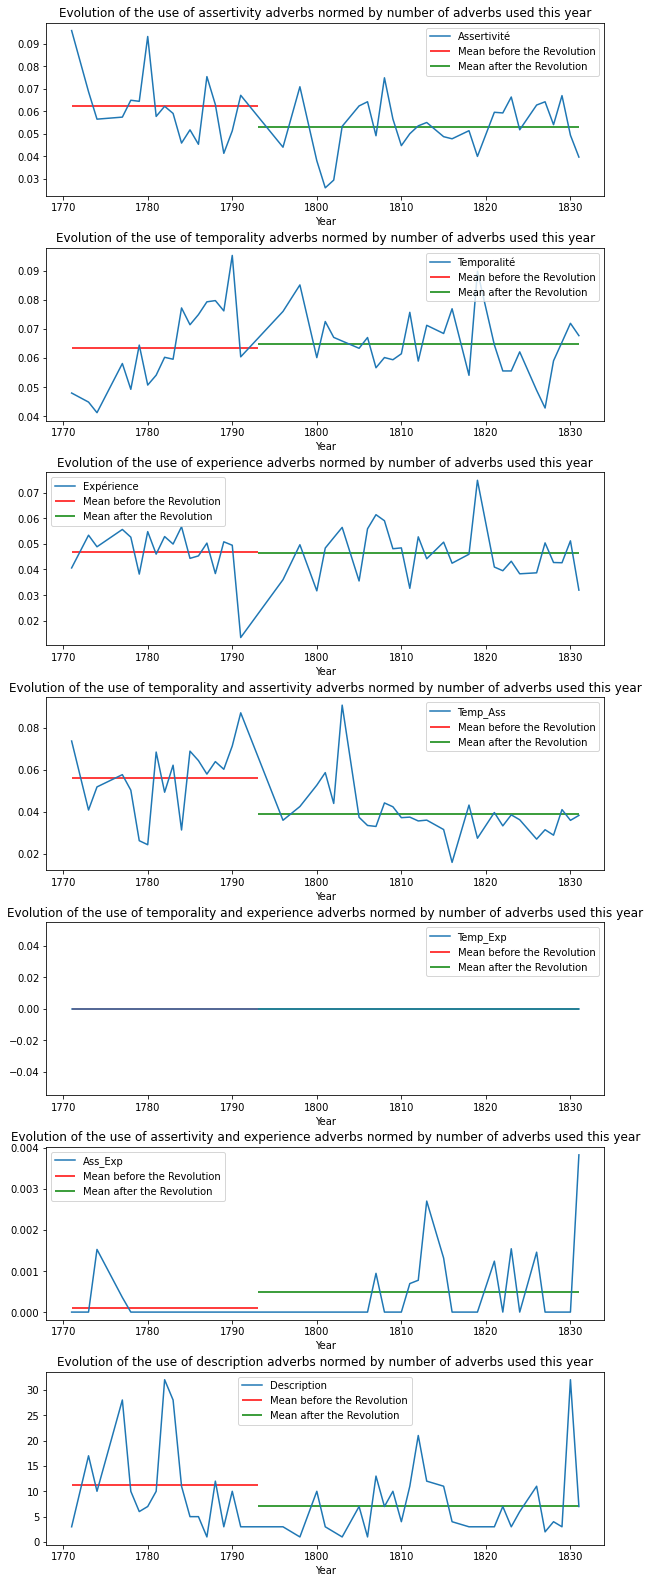

In [35]:
fig, ax = plt.subplots(nrows = 7, ncols=1, figsize = (10, 7*4))

ls = ['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp', 'Description']
ls_title = ['assertivity', 'temporality', 'experience', 'temporality and assertivity', 
           'temporality and experience', 'assertivity and experience', 'description']
for idx, cat in enumerate(ls):
    y1 = plot_adv_1[plot_adv_1.index<=1793][cat].mean()
    y2 = plot_adv_1[plot_adv_1.index>1793][cat].mean()
    plot_adv_1[[cat]].plot(kind='line', ax = ax[idx], xlabel='Year', title = 'Evolution of the use of ' +
                          ls_title[idx] + ' adverbs normed by number of adverbs used this year')
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Mean before the Revolution')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Mean after the Revolution')
    
        
    ax[idx].legend()
plt.subplots_adjust(hspace = 0.3)

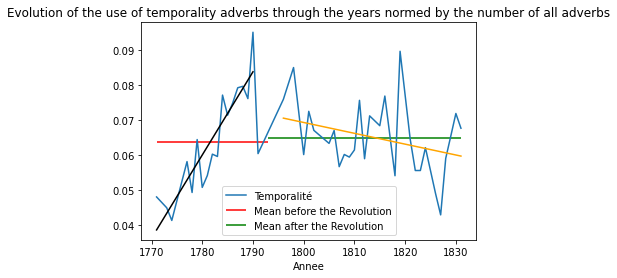

In [36]:
#Fitting a line for temporality

y1 = plot_adv_1[plot_adv_1.index<=1793]['Temporalité'].mean()
y2 = plot_adv_1[plot_adv_1.index>1793]['Temporalité'].mean()
plot_adv_1[['Temporalité']].plot(kind='line')
plt.hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Mean before the Revolution')
plt.hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Mean after the Revolution')


a, b = np.polyfit(np.array(plot_adv_1['Temporalité'].loc[:1790].index),np.array(plot_adv_1['Temporalité'].
                                                                                loc[:1790].values),1)
plt.plot(np.array(plot_adv_1['Temporalité'].loc[:1790].index), a*np.array(plot_adv_1['Temporalité'].
                                                                          loc[:1790].index)+b, color = 'black')

a, b = np.polyfit(np.array(plot_adv_1['Temporalité'].loc[1795:].index),np.array(plot_adv_1['Temporalité'].
                                                                                loc[1795:].values),1)
plt.plot(np.array(plot_adv_1['Temporalité'].loc[1795:].index), a*np.array(plot_adv_1['Temporalité'].
                                                                          loc[1795:].index)+b, color = 'orange')

plt.title('Evolution of the use of temporality adverbs through the years normed by the number of all adverbs')
plt.legend()

## Assertivity

Studying the assertivity

In [37]:
ass = adv.copy()
ass = ass[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
ass['adverbs'] = ass['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_ass or elem in ls_temp_ass
                                                                        or elem in ls_ass_exp)])

ass['Catégorie'] = ass['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Assertivité'][0]
                                                   for elem in x])

<AxesSubplot:title={'center':'Evolution of the kinds of assertivity in speech'}, xlabel='Year'>

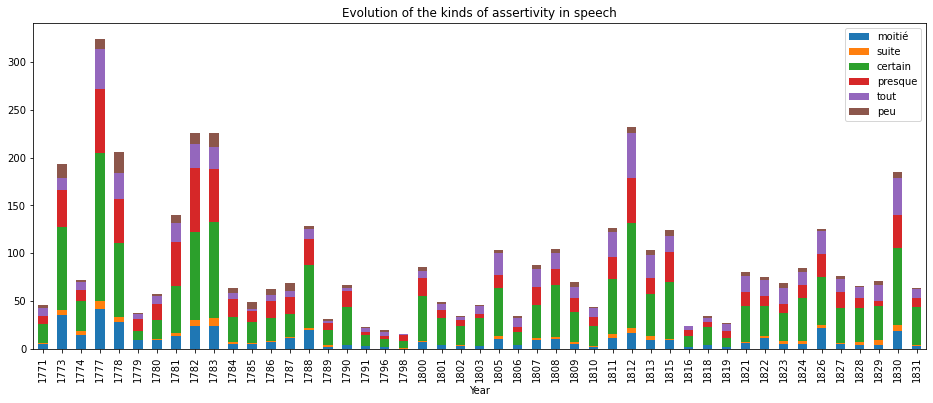

In [38]:
ls_cat = ass['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

for cat in ls_cat :
    ass[cat] = ass['Catégorie'].apply(lambda x : x.count(cat))
    
ass_plot = ass.groupby(['Annee'])[ls_cat].sum()

ass_plot.plot(kind='bar', stacked=True, figsize = (16,6), title = 'Evolution of the kinds of assertivity in speech',
             xlabel='Year')



Text(0.5, 0, 'Year')

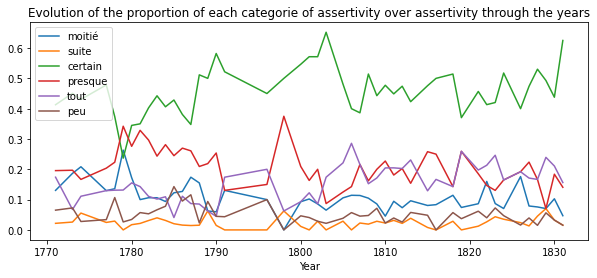

In [39]:
ass_plot['all'] = ass_plot.sum(axis=1)

for cat in ls_cat:
    ass_plot[cat] = ass_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    ass_plot[cat].plot(kind='line', figsize = (10,4), label=cat)
    
plt.legend()
plt.title('Evolution of the proportion of each categorie of assertivity over assertivity through the years')
plt.xlabel('Year')

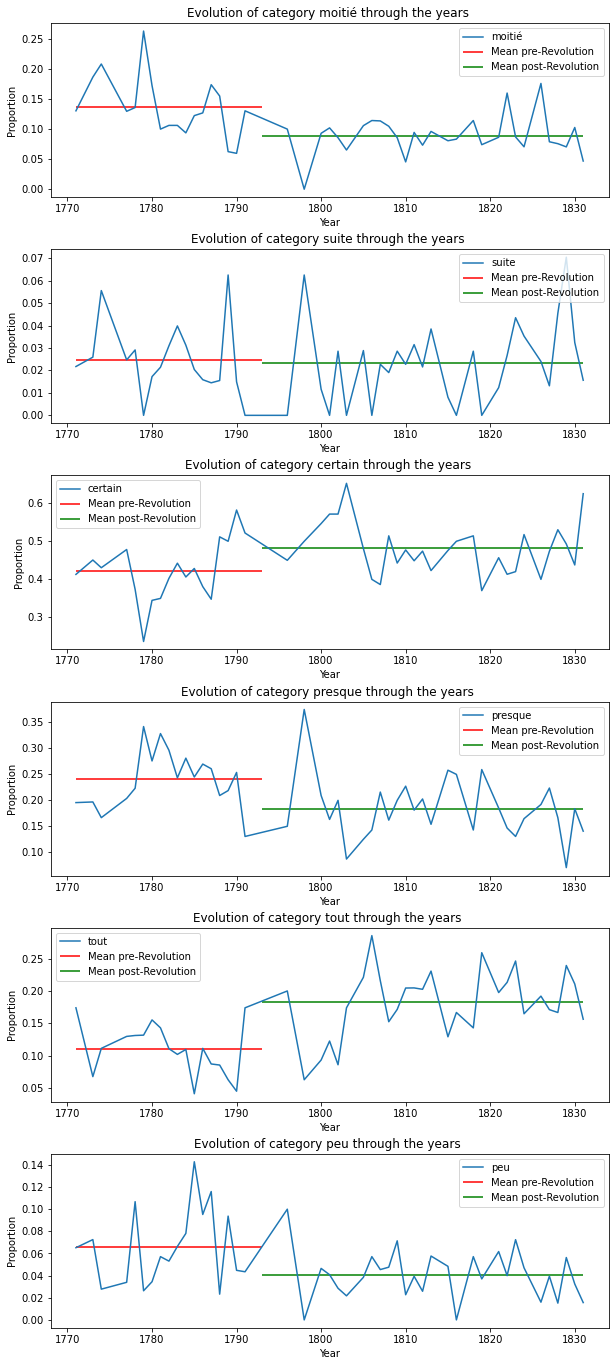

In [40]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, ls_cat.size*4))

for idx, cat in enumerate(ls_cat):
    y1 = ass_plot[ass_plot.index<=1793][cat].mean()
    y2 = ass_plot[ass_plot.index>1793][cat].mean()
    ass_plot[[cat]].plot(kind='line', ax = ax[idx])
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Mean pre-Revolution')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Mean post-Revolution')      
    ax[idx].legend()
    ax[idx].set_title('Evolution of category ' + cat + ' through the years ')
    ax[idx].set_xlabel('Year')
    ax[idx].set_ylabel('Proportion')
plt.subplots_adjust(hspace = 0.3)

## Temporality

In [41]:
temp = adv.copy()
temp = temp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
temp['adverbs'] = temp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_temp or elem in ls_temp_ass
                                                                        or elem in ls_temp_exp)])

temp['Catégorie'] = temp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Temporalité'][0]
                                                   for elem in x])

ls_cat = temp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['peu', 'presque', 'suite', 'maintenant', 'eternel', 'tot', 'passe',
       'tard', 'fréquence'], dtype=object)

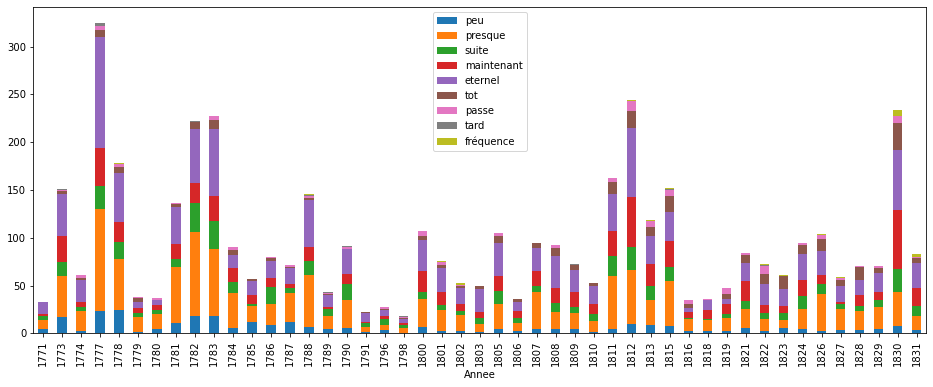

In [42]:
for cat in ls_cat :
    temp[cat] = temp['Catégorie'].apply(lambda x : x.count(cat))
    
temp_plot = temp.groupby(['Annee'])[ls_cat].sum()

temp_plot.plot(kind='bar', stacked=True, figsize = (16,6))

temp_plot['all'] = temp_plot.sum(axis=1)

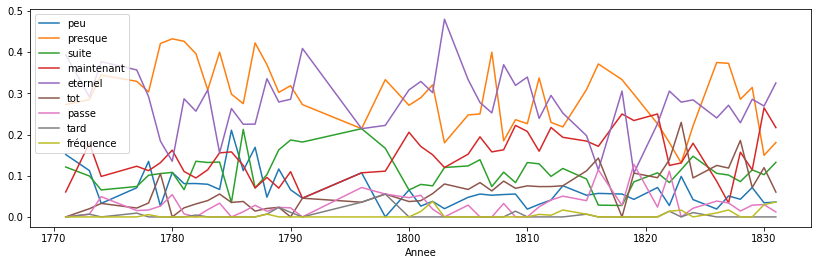

In [43]:
for cat in ls_cat:
    temp_plot[cat] = temp_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    temp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()

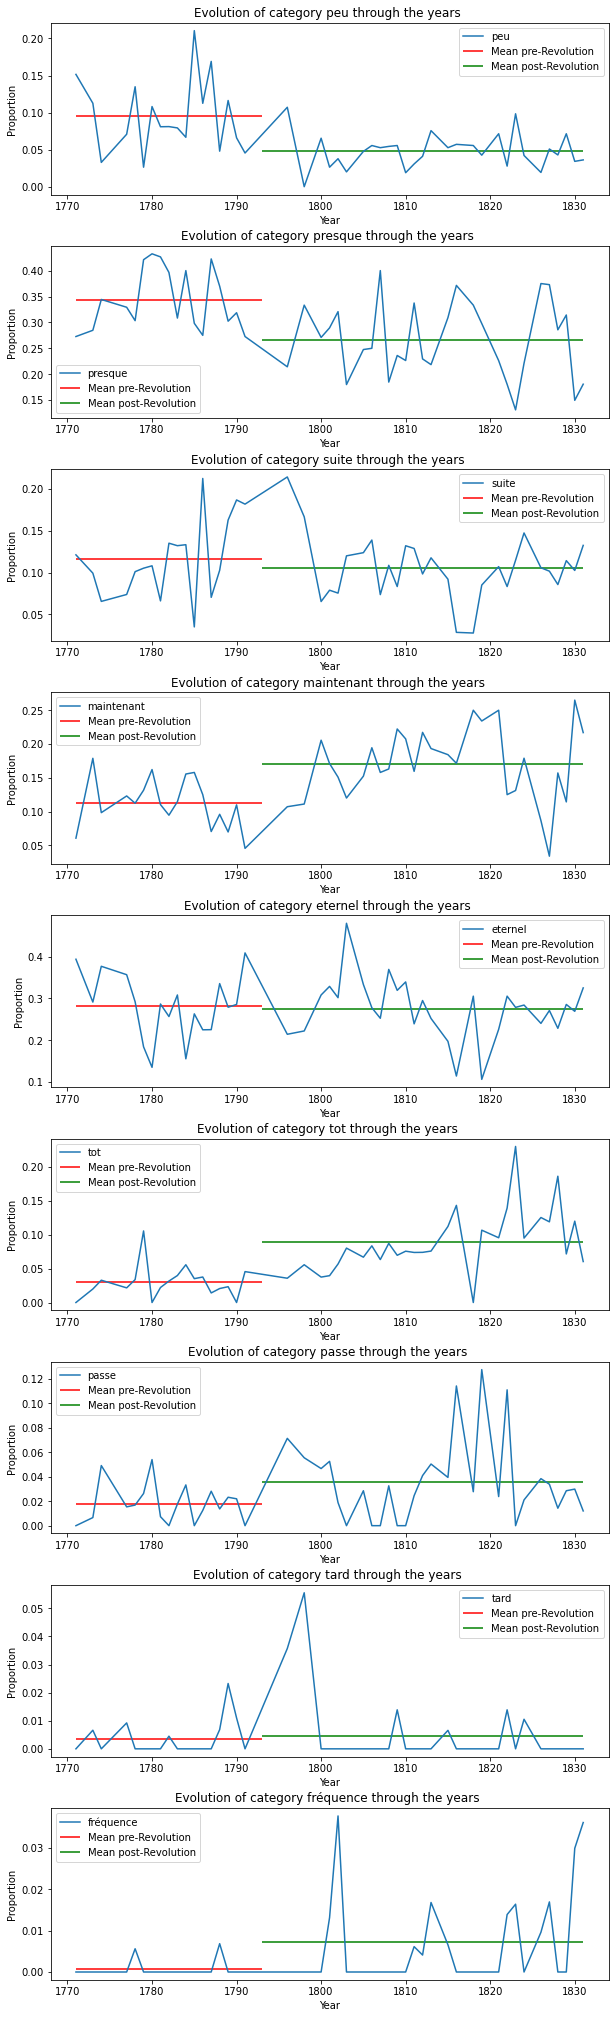

In [44]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, ls_cat.size*4))

for idx, cat in enumerate(ls_cat):
    y1 = temp_plot[temp_plot.index<=1793][cat].mean()
    y2 = temp_plot[temp_plot.index>1793][cat].mean()
    temp_plot[[cat]].plot(kind='line', ax = ax[idx])
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Mean pre-Revolution')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Mean post-Revolution')
    ax[idx].legend()
    ax[idx].set_title('Evolution of category ' + cat + ' through the years ')
    ax[idx].set_xlabel('Year')
    ax[idx].set_ylabel('Proportion')
        
plt.subplots_adjust(hspace = 0.3)

## Experience

In [45]:
exp = adv.copy()
exp = exp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
exp['adverbs'] = exp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_exp or elem in ls_temp_exp
                                                                        or elem in ls_ass_exp)])

exp['Catégorie'] = exp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Expérience'][0]
                                                   for elem in x])

ls_cat = exp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['moins', 'plus'], dtype=object)

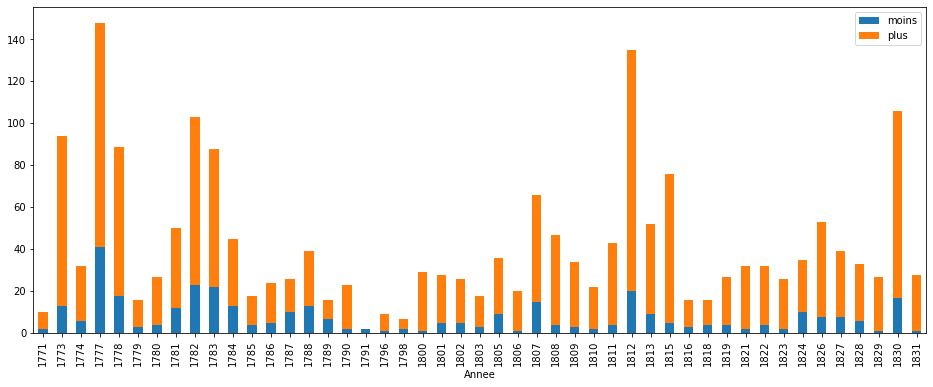

In [46]:
for cat in ls_cat :
    exp[cat] = exp['Catégorie'].apply(lambda x : x.count(cat))
    
exp_plot = exp.groupby(['Annee'])[ls_cat].sum()

exp_plot.plot(kind='bar', stacked=True, figsize = (16,6))

exp_plot['all'] = exp_plot.sum(axis=1)

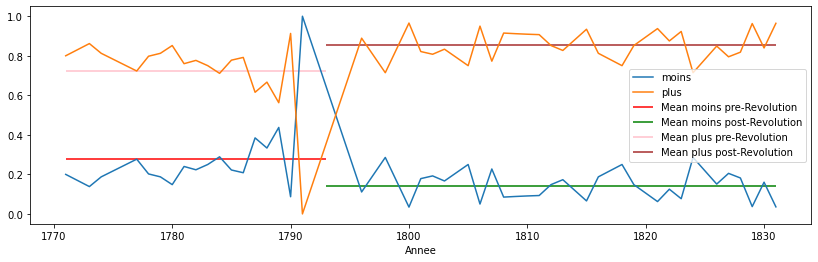

In [47]:
for cat in ls_cat:
    exp_plot[cat] = exp_plot.apply(lambda row : row[cat]/row['all'], axis=1)

ls=[('r', 'g'), ('pink', 'brown')]
    
for idx, cat in enumerate(ls_cat):
    y1 = exp_plot[exp_plot.index<=1793][cat].mean()
    y2 = exp_plot[exp_plot.index>1793][cat].mean()
    plt.hlines(y=y1, xmin = 1771, xmax = 1793, colors = ls[idx][0], label='Mean '+cat+' pre-Revolution')
    plt.hlines(y=y2, xmin = 1793, xmax = 1831, colors = ls[idx][1], label='Mean '+cat+' post-Revolution')
    exp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()

In [48]:
#Creating dataframe for obtaining most representative sentences for each adverb
df_h = keep_adv(df, 'Eloge')

In [49]:
#Most-representative sentences for each adverb
get_rep_adv(df_h, adv, df_ass, adv='adverbs')

P̲r̲e̲-̲R̲e̲v̲o̲l̲u̲t̲i̲o̲n̲ ̲:̲ 
Il avait, depuis l’âge de quarante ans environ, l’habitude de prendre tous les jours du vin de quinquina : il y renonça peu de temps avant sa mort ; et ce changement fut suivi d’un dépérissement prompt et rapide
Cependant, son goût pour les sciences était toujours le même ; et jusqu’à vingt-cinq ans ou environ, il y consacra tous les moments de relâche que ses douleurs lui laissaient
Dès ce moment, sa maladie changea de caractère ; une léthargie de trois jours succéda au seul accès de délire bien caractérisé qu'il ait éprouvé ; après ce temps, un réveil de quelques minutes, pendant lequel il parut avoir toute sa raison, fut suivi d’une nouvelle léthargie qui dura quatre jours ; ni les remèdes, ni les excitatifs ne pouvaient le tirer de cet état ; à peine était-il possible de lui faire avaler quelques gouttes d’eau ; ses membres étaient mous et flexibles ; les mouvements des artères étaient insensibles ; un battement de cour qu’on avait peine à saisir, 

In [50]:
get_rep_adv(df_h, adv, df_ass, adv='adverbs', adverb='toujours', categorie='Temporalité')

P̲r̲e̲-̲R̲e̲v̲o̲l̲u̲t̲i̲o̲n̲ ̲:̲ 
M Fontaine eut avec plusieurs géomêtres de ces disputes toujours surprenantes pour ceux qui, ne connaissant de la géométrie que les routes battues, ignorent que, dans la science même de la certitude le génie peut s’égarer quelquefois dans les routes nouvelles qu’il a osées se frayer
Je me suis arrêté longtemps sur Charles Perrault, en faisant l’éloge de son frère ; mais ils s’étaient toujours tendrement aimés, et c’est un hommage à la mémoire de notre académicien, que d’avoir consacré quelques lignes à défendre celle d’un frère qui lui fut si cher
Dans tous les problèmes sur les nombres qui se proposaient alors, on voyait toujours une solution de Frenicle à côté de celles de Descartes et de Fermat, qui avouèrent souvent que celle de Frenicle était plus élégante
P̲o̲s̲t̲-̲R̲e̲v̲o̲l̲u̲t̲i̲o̲n̲ ̲:̲ 
Son zèle eut à combattre et la briéveté du temps pendant lequel il put se préparer à un travail qu’il n’avoit pas prévu, et la grandeur du vaisseau dans leque

## h. Use of past tenses

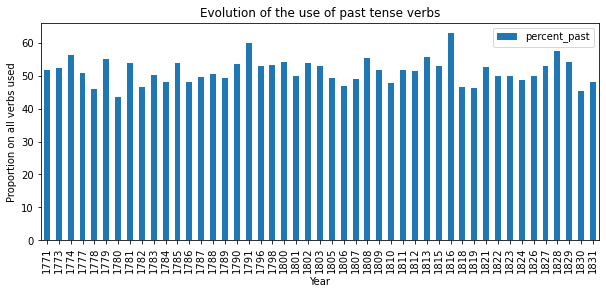

In [51]:
past_tense_df = past_tense(df)

In [53]:
past_tense_pre = past_tense_df[past_tense_df['Annee']<1793]
past_tense_post = past_tense_df[past_tense_df['Annee']>=1793]

ttest_ind(past_tense_pre['percent_past'].array, past_tense_post['percent_past'].array)

Ttest_indResult(statistic=-0.36054403998964396, pvalue=0.7201272821618027)

Reject Null Hypothesis the means are statistically different

## i. Starts with a statement on the birth

Number of eulogies that start with a statement on the birth

In [54]:
naissance(df)

In [55]:
print('Number of eulogies that start with a statement on the birth : ' + str(df[df['naissance'] == False].shape[0]))

Number of eulogies that start with a statement on the birth : 49


In [56]:
print('Number of eulogies that start with a statement on the birth before the Revolution : ' + 
      str(df[(df['naissance'] == False)&(df['Annee']<1793)].shape[0]))

Number of eulogies that start with a statement on the birth before the Revolution : 15


In [57]:
print('Number of eulogies that start with a statement on the birth after the Revolution : ' + 
      str(df[(df['naissance'] == False)&(df['Annee']>=1793)].shape[0]))

Number of eulogies that start with a statement on the birth after the Revolution : 34


## j. Use of Proper Names


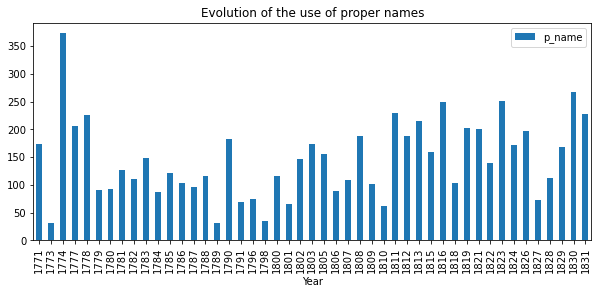

In [58]:
p_n = proper_name(df)

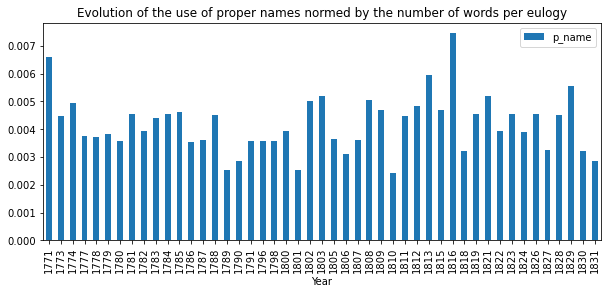

In [59]:
p_norm = proper_name(df, norm = True)

# 3. Second axis : Topic modeling

## Sentences to remove

In [52]:
sent[(sent['Eloge'].str.contains('Condorcet'))&(sent['Annee']<1796)]

Savant     Auteur  Annee                  Eloge
3173  Pascal  Condorcet  1778    (Page 133) Condorcet
3198  Pascal  Condorcet  1778   ) Condorcet          
3211  Pascal  Condorcet  1778   ) Condorcet          
3224  Pascal  Condorcet  1778    235) Condorcet      
3237  Pascal  Condorcet  1778   ) Condorcet          
3251  Pascal  Condorcet  1778    (P 290) Condorcet   
3260  Pascal  Condorcet  1778   ) Condorcet          
3270  Pascal  Condorcet  1778   ) Condorcet          
3277  Pascal  Condorcet  1778   ) Condorcet          
3361  Pascal  Condorcet  1778    309) Condorcet      
3377  Pascal  Condorcet  1778   ) Condorcet          
3386  Pascal  Condorcet  1778    325) Condorcet      
3404  Pascal  Condorcet  1778    331) Condorcet      
3417  Pascal  Condorcet  1778   ) Condorcet          
3422  Pascal  Condorcet  1778    391) Condorcet      
3430  Pascal  Condorcet  1778    462) Condorcet      
3440  Pascal  Condorcet  1778    491) Condorcet

In [53]:
sent = sent[(sent['Eloge'].str.contains('Condorcet')==False)|(sent['Annee']>1796)].reset_index()
#sent.drop('index')
sent.shape

(17767, 5)

In [54]:
sent.drop(columns = ['index'])

Savant     Auteur  Annee  \
0      Fontaine   Condorcet  1771    
1      Fontaine   Condorcet  1771    
2      Fontaine   Condorcet  1771    
3      Fontaine   Condorcet  1771    
4      Fontaine   Condorcet  1771    
...         ...         ...   ...    
17762  Desmarets  Cuvier     1815    
17763  Desmarets  Cuvier     1815    
17764  Desmarets  Cuvier     1815    
17765  Desmarets  Cuvier     1815    
17766  Desmarets  Cuvier     1815    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Eloge  
0      Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1       Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2       Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
3       Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donne

In [55]:
#Preprocessing the sentences
rmv_sw(sent, name_col = 'Eloge')
rmv_punkt(sent)
lemmatize(sent, 'no_sw_no_punkt', 'tags')
rmv_digit(sent)

In [56]:
#Only keeping nouns and verbs to avoid noise
nouns_verbs(sent, 'Eloge_lem', adj = True)

In [57]:
#Removing stop words and really short words that might still be here
sent['n_v'] = sent['n_v'].apply(lambda x : ' '.join([elem for elem in x.split() if (elem not in fr_stop and 
                                                                                    len(elem)>2)]))

In [58]:
#sent.reset_index(inplace = True)
sent.drop('index', axis = 1, inplace = True)
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

## Embedding models

I tested different embedding models and chose to stay with the sentence transformer as it was the one working  the best

In [59]:
np.random.seed(123)

model_sent = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#modelname = 'flaubert/flaubert_base_cased' 
#flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

#camembert = CamembertModel.from_pretrained('camembert/camembert-base-wikipedia-4gb')

## Bertopic

In [241]:
#Loading Bertopic with embedding model chosen and nr_topics to auto so that topic with more than 0.9 similarity are
#merged
model = BERTopic(embedding_model = model_sent, min_topic_size=20,
                 nr_topics='auto',calculate_probabilities = True, n_gram_range = (1,2))

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [242]:
topics, probabilities = model.fit_transform(sent.n_v)

In [60]:
#Loading the model

#model.save('./../../Data/Results/bert_model')
model = BERTopic.load('./../../Data/Results/bert_model')

In [61]:
#Loading the topics attributed to sentences

#with open("./../../Data/Results/topics", "wb") as fp:   #Pickling
 #   pickle.dump(topics, fp)
 
with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
    topics = pickle.load(fp)


In [62]:
#Loading the probabilities attributed to sentences

#with open("./../../Data/Results/probabilities", "wb") as fp:   #Pickling
 #   pickle.dump(probabilities, fp)
    
    
with open("./../../Data/Results/probabilities", "rb") as fp:   # Unpickling
    probabilities = pickle.load(fp)

In [63]:
#Creating a dataframe to see most representative sentences for each topic

df_rep = pd.DataFrame({'Topic': topics, 'Document': sent.Eloge_lem, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

df_rep['Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Topic']], axis = 1)
df_rep['All_Probs'] = df_rep.apply(lambda row : probabilities[row.name], axis = 1)

df_rep['Scd_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-2])
df_rep['Fst_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-1])

In [64]:
df_same = df_rep[df_rep.apply(lambda x : x['Fst_Topic']==x['Scd_Topic'], axis=1)]
df_same.shape

(0, 10)

In [65]:
df_same = df_rep[df_rep.apply(lambda x : x['Fst_Topic']==x['Topic'], axis=1)]
df_same.shape

(5485, 10)

In [66]:
df_same.Fst_Topic.value_counts()

0     1363
4     353 
5     317 
6     284 
3     257 
7     243 
8     220 
1     210 
13    152 
9     126 
11    125 
19    101 
15    100 
2     99  
21    89  
12    85  
10    85  
14    69  
17    69  
25    64  
30    61  
18    59  
28    58  
23    58  
27    55  
20    55  
29    52  
16    46  
24    43  
33    43  
32    43  
26    42  
36    37  
37    34  
35    33  
22    33  
31    32  
41    32  
34    31  
38    30  
39    29  
40    28  
42    27  
44    27  
45    24  
43    22  
46    20  
47    20  
Name: Fst_Topic, dtype: int64

In [67]:
#Loading information about the topics

df_info = model.get_topic_info()
df_info

Topic  Count  \
0  -1      10027   
1   0      1363    
2   1      524     
3   2      469     
4   3      422     
5   4      414     
6   5      374     
7   6      366     
8   7      347     
9   8      336     
10  9      230     
11  10     212     
12  11     190     
14  12     173     
13  13     173     
15  14     142     
16  15     134     
17  16     125     
18  17     112     
19  18     110     
20  19     101     
21  20     97      
22  21     96      
23  22     91      
25  23     85      
24  24     85      
26  25     71      
27  26     68      
28  27     67      
29  28     65      
30  29     61      
31  30     61      
32  31     47      
33  32     43      
34  33     43      
35  34     42      
37  35     38      
36  36     38      
38  37     37      
39  38     36      
40  39     34      
41  40     34      
42  41     32      
43  42     30      
44  43     29      
45  44     27      
46  45     24      
47  46     21      
48  47     21      

                                                                      Name  
0   -1_faire_homme_pouvoir_grand                                            
1   0_animal_euler_loi_équation                                             
2   1_fil_père_fils_fil fil                                                 
3   2_science_progrès_savant_homme                                          
4   3_médecin_maladie_malade_médeciner                                      
5   4_card_card card_publier_année                                          
6   5_jardin_botanique_planter_botaniste                                    
7   6_air_acide_eau_sel                                                     
8   7_pierre_minéral_montagne_rocher                                        
9   8_astronome_astronomie_observation_mouvement                            
10  9_chimie_chimiste_chimiquer_substance                                   
11  10_philosophie_philosophe_poète_philosopher                             
12  11_prince_roi_royal_vouloir                                             
14  12_jeune_jeunesse_jeune homme_homme                                     
13  13_rayon_lumière_rayer raire_rayer                                      
15  14_génie_homme génie_homme_grand                                        
16  15_mémoire_souvenir_oublier_rappeler                                    
17  16_imprimer_écrire_manuscrit_édition                                    
18  17_naturel_nature_histoire naturel_histoire                             
19  18_artiste_art_talent_savant artiste                                    
20  19_géomètre_géométrie_méthode_problème                                  
21  20_théorie_général_expérience_théorie terre                             
22  21_religion_religieux_chrétien_dieu                                     
23  22_langue_latin_livre_traduction                                        
25  23_expérience_expérience faire_expérience direct_répéter expérience     
24  24_travail_carrière_temps_devoir                                        
26  25_anatomie_histoire_histoire naturel_naturel                           
27  26_ministre_ministère_gouvernement_ennemi                               
28  27_mathématique_mathématicien_calcul_étude mathématique                 
29  28_année_dernier année_dernier_année marquer                            
30  29_mois moi_mois_moi_dernier mois                                       
31  30_fluide_mouvement_corps_équilibre                                     
32  31_force_forces_force forces_force force                                
33  32_catholique_clergé_protester_religion                                 
34  33_horloge_horlogerie_penduler_perfection                               
35  34_marquis_colonel_maréchal_régiment                                    
37  35_impôt_payer_peuple_indirect                                          
36  36_matériau_matériau matériau_matériaux matériau_matériaux              


In [68]:
#Printing most representative sentences for one topic

_ = sent_rep(0, df_rep)

 Rarement les yeux d’un artiste aperçoivent les mêmes choses que ceux de l’observateur éclairé par l’étude et par l’expérience


 Et l'on ne peut s'empécher de voir encore ici un effet de la modestie de M Berthollet et du peu d'insistance qu'il mettait à faire prévaloir les choses auxquelles il avait le plus de part


 Rousseau ; il avait été dans sa jeunesse, aux îles d'Hières, à la Grande-Chartreuse et dans les Pyrénées


 Les auteurs de logiques ne ressemblent que trop souvent aux mécaniciens qui donnent des descriptions d’instruments dont ils ne seraient pas en état de se servir


 Le calcul aux différences finies n’était presque connu que par l’ouvrage obscur, mais plein de sagacité, de Taylor : M Euler en fit une branche importante du calcul intégral, lui donna une notation simple et commode, et sut l’appliquer avec succès à la recherche de leurs sommes, ou de l’expression de leurs termes généraux, à celle de la racine des équations déterminées, à la manière d’avoir, par un calcu

## Hierarchical clustering

In [69]:
#Classifying the topic in upper categories
topic_medecine = [3]
topic_ciel = [8]
topic_vie = [1, 4, 12, 24, 28, 29, 31, 44, 47]
topic_biologie = [5, 17, 25]
topic_geologie = [7]
topic_chimie = [6, 9]
topic_politique = [11, 26, 34, 35, 39, 40]
topic_philosophie = [10]
topic_physique = [13, 30, 33, 38, 42]
topic_mathematiques = [19, 27]
topic_methode = [20, 23, 36, 45, 46]
topic_religion = [21, 32]
topic_memoire = [15, 16, 22]
topic_voyage = [43]
topic_perso = [2, 14, 18, 37, 41]

In [70]:
topic_dict = {'medecine' : topic_medecine, 'astronomie' : topic_ciel, 'vie' : topic_vie, 'biologie' : topic_biologie,
             'geologie' : topic_geologie, 'chimie' : topic_chimie, 'politique' : topic_politique,
             'philosophie' : topic_philosophie, 'physique' : topic_physique, 
             'mathematiques' : topic_mathematiques, 'methode' : topic_methode, 'religion' : topic_religion,
             'memoire' : topic_memoire, 'voyage' : topic_voyage, 'représentation' : topic_perso}


In [71]:
#higher topics

topic_science = (topic_ciel + topic_chimie + topic_biologie + topic_philosophie + topic_physique
                + topic_mathematiques + topic_medecine + topic_geologie)
topic_personne = topic_vie + topic_perso
topic_posterite = topic_memoire 
topic_societe = topic_religion + topic_politique
topic_theorie = topic_methode

In [72]:
high_dict = {'science' : topic_science, 'personne' : topic_personne, 'posterite' : topic_posterite,
            'societe' : topic_societe,'theorie' : topic_theorie, 'voyage' : topic_voyage}

In [73]:
#BERTmodel hierarachy

model.visualize_hierarchy()

In [74]:
#Plot the hierarchy made and saving it as html file

df_plot = df_info.copy()
df_plot['High_High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, high_dict)[1])
df_plot['High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, topic_dict)[1])
df_plot = df_plot[df_plot['High_Topic']!='outlier']
df_plot['Phrase'] = df_plot['Topic'].apply(lambda x : sent_rep(x, df_rep, print_=False).Eloge.tolist())
df_plot = df_plot.explode('Phrase')

fig = px.icicle(df_plot, path=[px.Constant("all"), 'High_High_Topic', 'High_Topic', 'Name', 'Phrase'])
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
fig.write_html('./../../Data/Results/hierarchy.html')

## Topics over time

Studying the evolution of topics over time

In [75]:
df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

df_top['Words'] = df_top['Topic'].apply(lambda x : df_info[df_info['Topic']==x].reset_index()['Name'][0])
df_top['Words'] = df_top['Words'].apply(lambda x : ', '.join(x.split('_')[1:]))

In [76]:
#Normalize by number of sentences

topics_over_time_norm = df_top.groupby(['Annee', 'Topic', 'Words'])['Eloge'].count().reset_index()
topics_over_time_norm.rename(columns = {'Annee' : 'Timestamp', 'Eloge' : 'Frequency'}, inplace = True)

topics_over_time_norm.head()

Timestamp  Topic                                Words  Frequency
0  1771      -1      faire, homme, pouvoir, grand         73       
1  1771       0      animal, euler, loi, équation         17       
2  1771       1      fil, père, fils, fil fil             4        
3  1771       2      science, progrès, savant, homme      3        
4  1771       3      médecin, maladie, malade, médeciner  1

In [77]:
df_by_year = df.groupby('Annee')['Eloge'].count().reset_index()
sent_by_year = sent.groupby('Annee')['Eloge'].count().reset_index()

In [78]:
sent_topic_time = topics_over_time_norm.copy()

topics_over_time_norm = pd.merge(topics_over_time_norm, df_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')
topics_over_time_norm.head()

Timestamp  Topic                                Words  Frequency  Annee  \
0  1771      -1      faire, homme, pouvoir, grand         73         1771    
1  1771       0      animal, euler, loi, équation         17         1771    
2  1771       1      fil, père, fils, fil fil             4          1771    
3  1771       2      science, progrès, savant, homme      3          1771    
4  1771       3      médecin, maladie, malade, médeciner  1          1771    

   Eloge  
0  1      
1  1      
2  1      
3  1      
4  1

In [79]:
sent_topic_time = pd.merge(sent_topic_time, sent_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')

In [80]:
topics_over_time_norm['Frequency'] = topics_over_time_norm.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
topics_over_time_norm.pop('Eloge')
topics_over_time_norm.pop('Annee')

sent_topic_time['Frequency'] = sent_topic_time.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
sent_topic_time.pop('Eloge')
sent_topic_time.pop('Annee')

0       1771
1       1771
2       1771
3       1771
4       1771
        ... 
1355    1831
1356    1831
1357    1831
1358    1831
1359    1831
Name: Annee, Length: 1360, dtype: int64

In [81]:
bins = sent.Annee.unique().shape[0]
topics_over_time = model.topics_over_time(sent.n_v, topics, sent.Annee, nr_bins=bins)
topics_over_time

Topic  \
0    -1       
1     0       
2     1       
3     2       
4     3       
...  ..       
1172  43      
1173  44      
1174  45      
1175  46      
1176  47      

                                                                                                   Words  \
0     homme, faire, gloire, donner, méthode                                                                
1     équation, intégral, différentiel, équation ordre, homogène                                           
2     parent, père, génie province, charge styler, commentateur loi                                        
3     flatter entrée, réunir paisible, paraître flatter, abstrait commerce, pouvoir événement              
4     nature absurde, absurde plaindre, regarder douleur, mourir suite, douleur mourir                     
...                                                                                ...                     
1172  tour, scrupule encourager, élever cordouan, empresser autoriser, embouchure installer                
1173  dater ode, paille divergent, saint poême, poême, poême meilleur                                      
1174  solution inconvénient, reconnaître solution, possession moyen, décomposition puissant, aller hâter   
1175  rechercher question, citer raison, mériter citer, important conséquence, bizarrerie phénomène        
1176  vie, fin vie, fin, vie vie, vivre                                                                    

      Frequency  Timestamp  
0     73         1770.940   
1     17         1770.940   
2     4          1770.940   
3     3          1770.940   
4     1          1770.940   
...  ..               ...   
1172  2          1829.723   
1173  3          1829.723   
1174  2          1829.723   
1175  2          1829.723   
1176  1          1829.723   

[1177 rows x 4 columns]

In [82]:
#Normalized by number of sentences


model.visualize_topics_over_time(sent_topic_time)

In [83]:
#Normalized by number of eulogies

model.visualize_topics_over_time(topics_over_time_norm)

- Augmentation après Révolution de science_progrès_savant_homme
- Médecin plus mentionné topic 3 avant Révolution puis pic en 1828
- Pic topic 4 en 1830, card_card card_publier_année
- Pic topic 5 en 1800, 1805, 1828
- Pic en 1830 pour topic 14 génie_homme_génie
- Pic pour imprimer topic 16 en 1804
- Pic en 1773 pour topic 19 géométrie
- Pic en 1830 pour topic 6 air_acide_eau_sel
- Pic pour topic 7 pierre_minéral_montagne_rocher 1818 et 1822
- Augmentation topic astronomie topic 8 après révolution
- Topic 10 philosophie plus mentionné avant la Révolution
- Topic 11 prince_roi_royal_vouloir plus mentionné avant la Révolution, à nouveau re-mentionné après 1816
- Pic pour topic 12 jeunesse en 1903
- Pic topic 13 rayon_lumière_rayer
- Pic topic 18 artiste_savant_art en 1810 et 1825
- Pic topic 21 pour religion en 1778 et 1790, très peu mentionné après la Révolution
- Pic topic 23 expérience en 1830
- Pic topic 25 anatomie en 1804
- Pic topic ministère en 1790
- Pic topic 29 mois en 1804
- Diminution topic 30 au fur et à mesure du temps re-augmentation à partir de 1815
- Agumentation topic 31 force au fur et à mesure du temps
- Augmentation toipc 33 horloge jusqu'à 1810 puis abrupte diminution
- Pic topic 37 abbé en 1786
- Pic topic 38 en 1773 et 1830
- Pic topic 41 en 1825
- Abrupt diminution en 1805 du topic 32 catholique
- Topic 35 impôt plus mentionné après 1805 et diminution à partir de 1790
- Toipc 39 révolution mentionné plus à partir de 1790
- Topic 40 pic guerre paix en 1795
- Pic topic électricité en 1830 topic 42

## Structure of an eulogy

In [92]:
df_top['Topic'] = df_top['Topic'].apply(lambda x :(x,  df_info[df_info['Topic']==x].reset_index()['Name'][0]))

In [93]:
#Setting higher higher topic
df_top['High_High_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], high_dict))

In [94]:
#Setting higher topic
df_top['Higher_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], topic_dict))

In [95]:
df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)

#Reconstructing the eulogy from order of sentences with the topic
reconstruct = df_top.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
df_sent['Eloge'] = df_sent['Eloge'].apply(lambda x : x.split('.'))
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [96]:
#Storing colors
colors = []
for i in range(0, 16):
    for j in range(0, 16):
        code = str(i * 16 + j)
        #sys.stdout.write(u"\u001b[38;5;" + code + "m " + code.ljust(4))
        colors.append(u"\u001b[38;5;" + code + "m ")
    #print(u"\u001b[0m")

In [97]:
for sentence, topic in df_sent['Tuple_topic_sent'][2]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 -1_faire_homme_pouvoir_grand   --->  Marin Cureau de la Chambre, médecin ordinaire du roi, naquit au Mans vers 1613
 3_médecin_maladie_malade_médeciner   ---> Le chancelier Séguier se l’attacha, moins pour son habileté dans la médecine, que pour l’étendue et la variété de Ses connaissances
 26_ministre_ministère_gouvernement_ennemi   ---> La confiance de ce ministre fournissait à la Chambre le moyen d’être utile aux gens de lettres, et il en saisissait avidement toutes les occasions
 2_science_progrès_savant_homme   ---> Il était bien éloigné de dédaigner les Sciences après avoir fait fortune par elles : espèce d’ingratitude qui n’est malheureusement que trop commune
 -1_faire_homme_pouvoir_grand   ---> Le cardinal de Richelieu lui donna une place dans l’Académie française, lors de Son établissement en 1635, et le chargea, en 1640, de répondre au livre de Hersant, en faveur des prétentions de la cour de Rome
 -1_faire_homme_pouvoir_grand   ---> Ce livre fut regardé en France comme séd

In [98]:
for sentence, topic in df_sent['Tuple_topic_sent'][131]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)


 -1_faire_homme_pouvoir_grand   --->Messieurs, Le nom de Laplace a retenti, dans tous les lieux du monde où les sciences sont honorées : mais sa mémoire ne pouvait recevoir un plus digne hommage que le tribut unanime de l'admiration et des regrets du corps illustre dont il a partagé les travaux et la gloire
 -1_faire_homme_pouvoir_grand   ---> Il a consacré sa vie à l'étude des plus grands objets qui puissent occuper l'esprit humain
 -1_faire_homme_pouvoir_grand   ---> Les merveilles du ciel, les hautes questions de la philosophie naturelle, les combinaisons ingénieuses et profondes de l'analyse mathématique, toutes les lois de l'univers, ont été présentes à sa pensée pendant plus de soixante années, et ses efforts ont été couronnés par des décou vertes immortelles On remarqua, dès ses premières études, qu'il était doué d'une mémoire prodigieuse : toutes les occupations de l'esprit lui étaient faciles
 22_langue_latin_livre_traduction   ---> Il acquit rapidement une instruction assez é

In [99]:
for sentence, topic in df_sent['Tuple_topic_sent'][135]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 5_jardin_botanique_planter_botaniste   --->Messieurs, L'ambre jaune, lorsqu'il a été frotté, attire vivement les corps légers, tels que des barbes de plumes, des brins de paille, de la sciure de bois
 -1_faire_homme_pouvoir_grand   ---> Théophraste, parmi les Grecs, Pline, chez les Romains, citèrent déja cette propriété, mais sans paraître y attacher plus d'importance qu'à un simple accident de forme ou de couleur
 -1_faire_homme_pouvoir_grand   ---> Ils ne se doutèrent pas qu'ils venaient de toucher au premier anneau d'une longue chaine de découvertes ; ils méconnurent l'importance d'une observation qui, plus tard, devait fournir des moyens assurés de désarmer les nuées orageuses, de conduire, dans les entrailles de la terre, sans danger et même sans explosion, la foudre que ces nuées recèlent
 42_électricité_électrique_corps_physicien   ---> Le nom grec de l'ambre, électron, a conduit au mot électricité, par lequel on désigna d'abord la puissance attractive des corps frottés
 2_scie

## Percent of topic per range 

In [100]:
def organise_topic(df, eloge = 'Eloge', topic = 'Topic', major = df):
    '''
    This method aims at reconstructing the eulogies with the sentences with the corresponding topics
    Inputs:
        - df (DataFrame) : dataframe containing the sentences and their corresponding topics
        - eloge (string) : name of the column containing the sentences, by default to 'Eloge'
        - topic (string) : name of the column containing the topics, by default to 'topic'
        - major (DataFrame) : dataframe containing the eulogies not divided by sentences, by default to df
    Output:
        - df_sent (DataFrame) : dataframe with two additionnal columns, one containing the tuples (topic, sentence)
                                ordered and another one with solely the topics ordered
    '''
    df['Tuple_' + topic + '_sent'] = df.apply(lambda row : (row[eloge], row[topic]), axis=1)
    
    reconstruct = df.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_' + topic + '_sent'].apply(list).reset_index()
    
    df_sent = major.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
    df_sent[eloge] = df_sent[eloge].apply(lambda x : x.split('.'))
    df_sent['Tuple_'+topic+'_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_'+topic+'_sent'], 
                                                                         key=lambda x: row[eloge].index(x[0])),
                                                               axis = 1)
    df_sent['Topic_Ordered'] = df_sent['Tuple_'+topic+'_sent'].apply(lambda x : [elem[1] for elem in x])
    return df_sent

In [101]:
#Organizing by topic
df_sent_t = organise_topic(df_top)

#Organizing by second level of hierarchy
df_sent_h = organise_topic(df_top, topic ='Higher_Topic')

#Organizing by first level of hierarchy
df_sent_hh = organise_topic(df_top, topic ='High_High_Topic')

## By first-level topic

144it [00:00, 15708.19it/s]
79it [00:00, 16915.97it/s]
65it [00:00, 17251.77it/s]


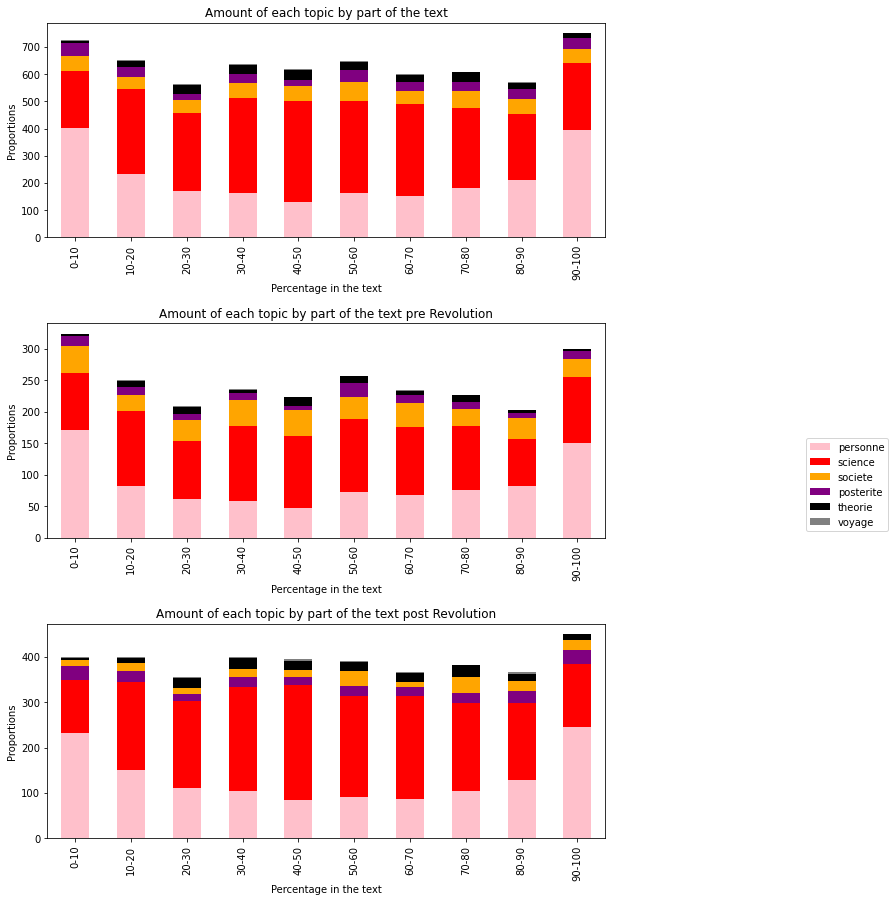

In [105]:
test,_,_ = plot_stack_bar(df_sent_hh)

144it [00:00, 19644.81it/s]
79it [00:00, 18730.92it/s]
65it [00:00, 10826.37it/s]


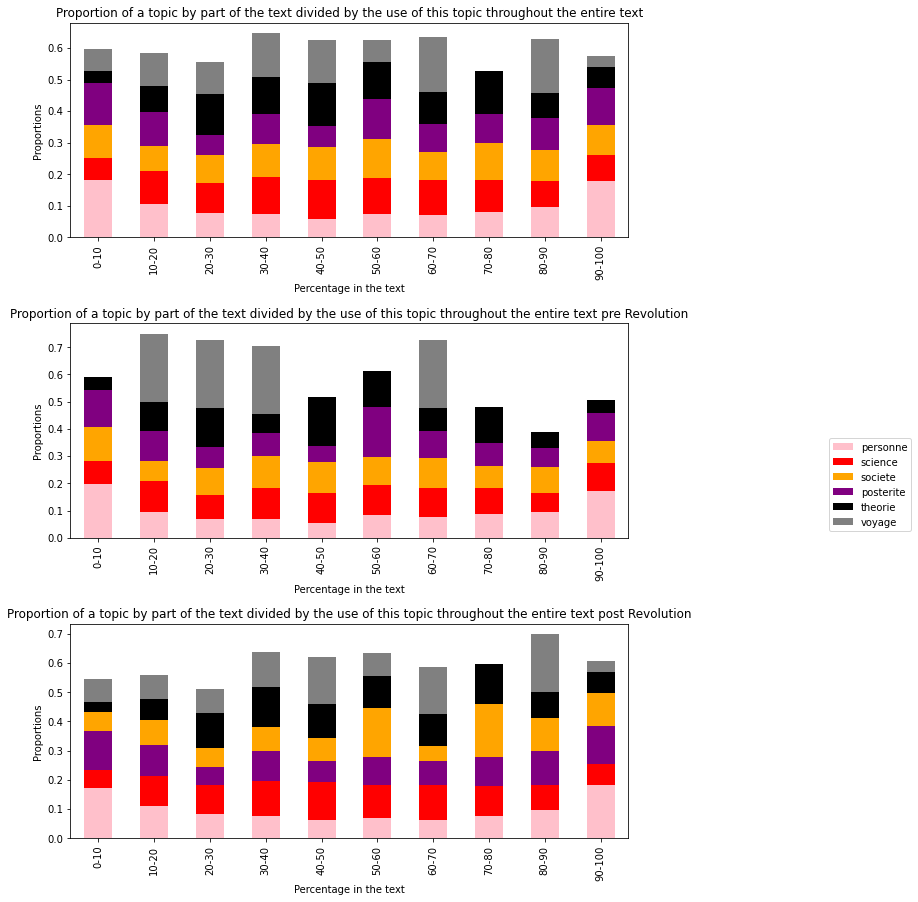

In [106]:
test,_,_ = plot_stack_bar(df_sent_hh, norm_by_tot=True)

No major differences

144it [00:00, 19272.46it/s]
79it [00:00, 19113.41it/s]
65it [00:00, 15133.49it/s]


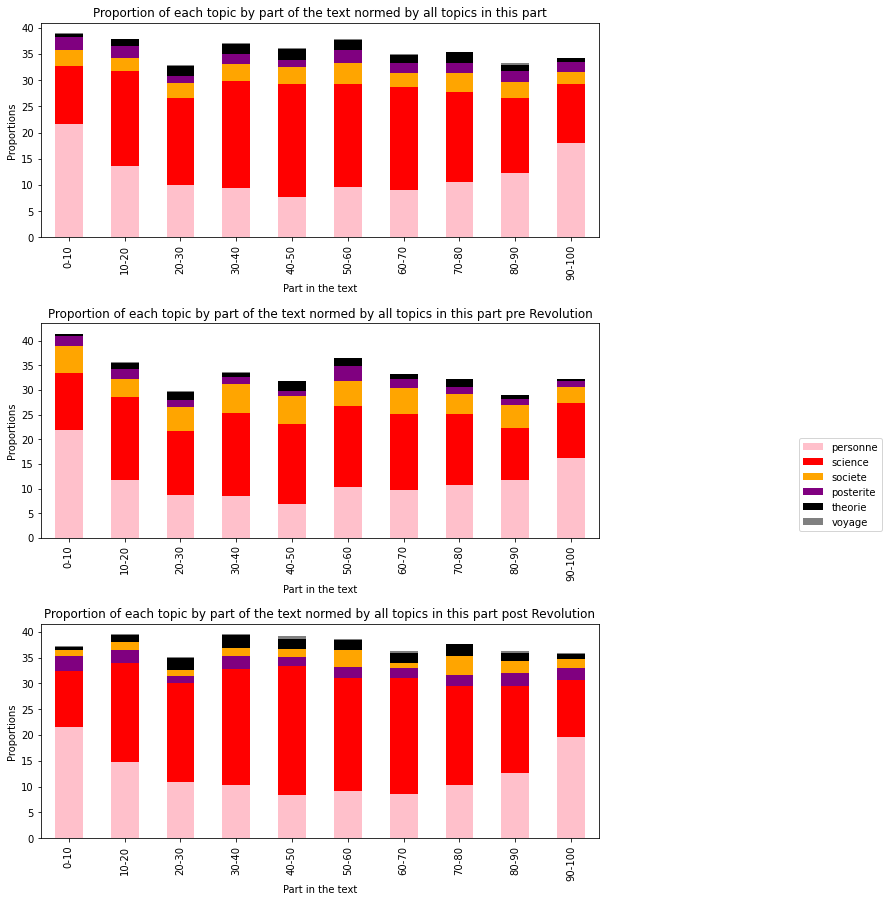

In [107]:
_,_,_ = plot_stack_bar(df_sent_hh, norm = True)

We speak more of politics before the Revolution, and more of travel after the Revolution

## Vie

In [108]:
df_vie = df_sent_t.copy()
df_vie['Topic_Ordered'] = df_vie['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_vie])

144it [00:00, 20405.41it/s]
79it [00:00, 23711.89it/s]
65it [00:00, 21008.69it/s]


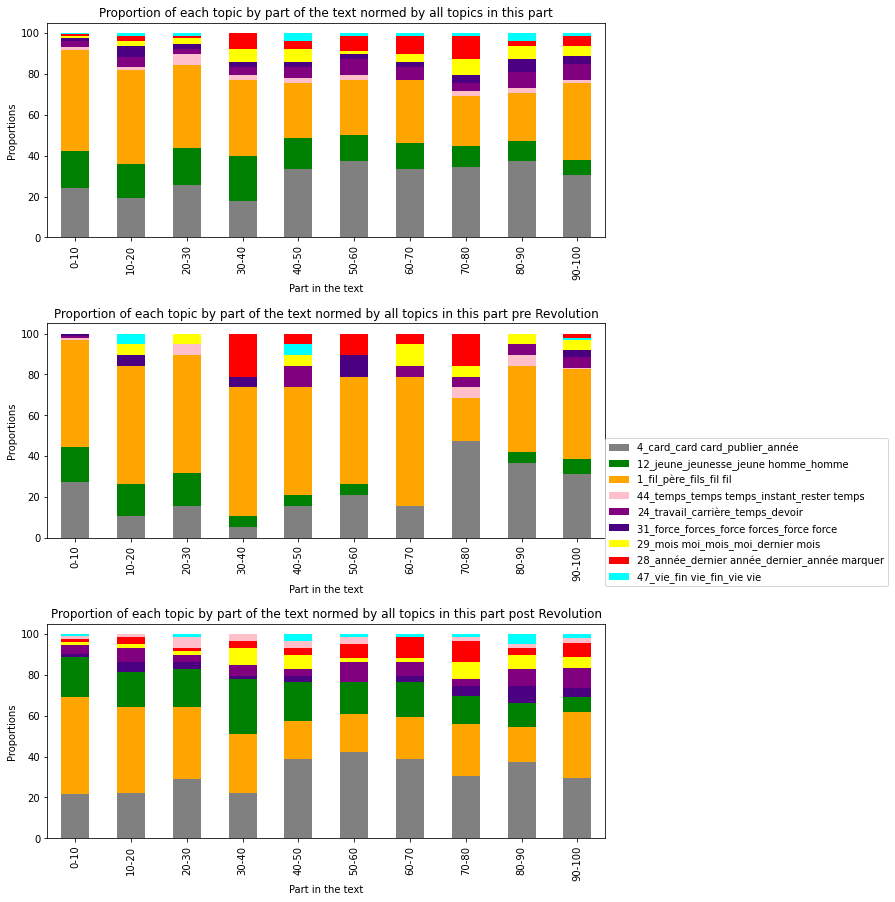

In [109]:
color_p = {'4_card_card card_publier_année' : 'grey', '12_jeune_jeunesse_jeune homme_homme' : 'green', '1_fil_père_fils_fil fil' :
          'orange', '44_temps_temps temps_instant_rester temps' : 'pink', '24_travail_carrière_temps_devoir' : 'purple',
          '29_mois moi_mois_moi_dernier mois' : 'yellow', '28_année_dernier année_dernier_année marquer' : 'red',
          '47_vie_fin vie_fin_vie vie' : 'cyan', '31_force_forces_force forces_force force' : 'indigo'}

_,_,_= plot_stack_bar(df_vie, keep_outliers = True, color_plot = color_p, norm = True)

On parle plus de la famille pre-revolution

## Politique & Religion

In [110]:
df_pol = df_sent_t.copy()
df_pol['Topic_Ordered'] = df_pol['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_societe])

144it [00:00, 25240.49it/s]
79it [00:00, 21762.12it/s]
65it [00:00, 19860.84it/s]


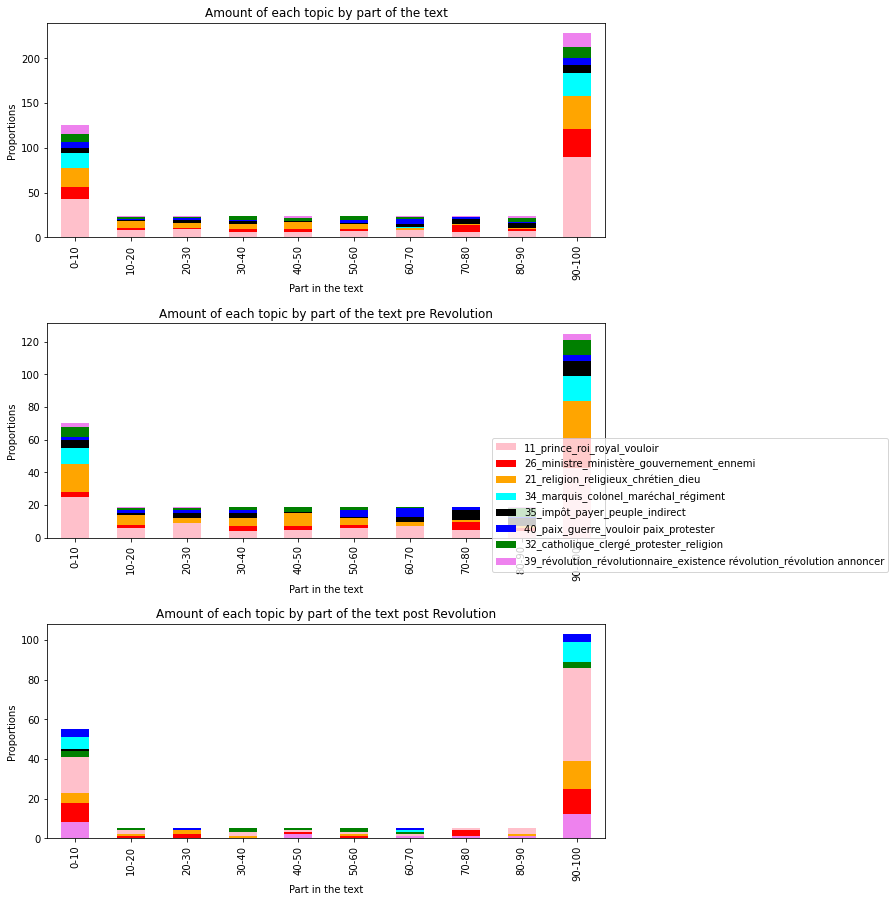

In [111]:
color_p = {'11_prince_roi_royal_vouloir' : 'pink', '26_ministre_ministère_gouvernement_ennemi' : 'red',
          '21_religion_religieux_chrétien_dieu' : 'orange', '35_impôt_payer_peuple_indirect' : 'black',
          '40_paix_guerre_vouloir paix_protester' : 'blue', '32_catholique_clergé_protester_religion' : 'green',
          '39_révolution_révolutionnaire_existence révolution_révolution annoncer' : 'violet', 
          '34_marquis_colonel_maréchal_régiment' : 'cyan'}

_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = False)

Politique plus évoquée tout le long de l'éloge avant la révolution, particulièrement loi peuple nation pas hasard chancelier occuper perdre

144it [00:00, 26267.98it/s]
78it [00:00, 22766.58it/s]
66it [00:00, 22366.01it/s]


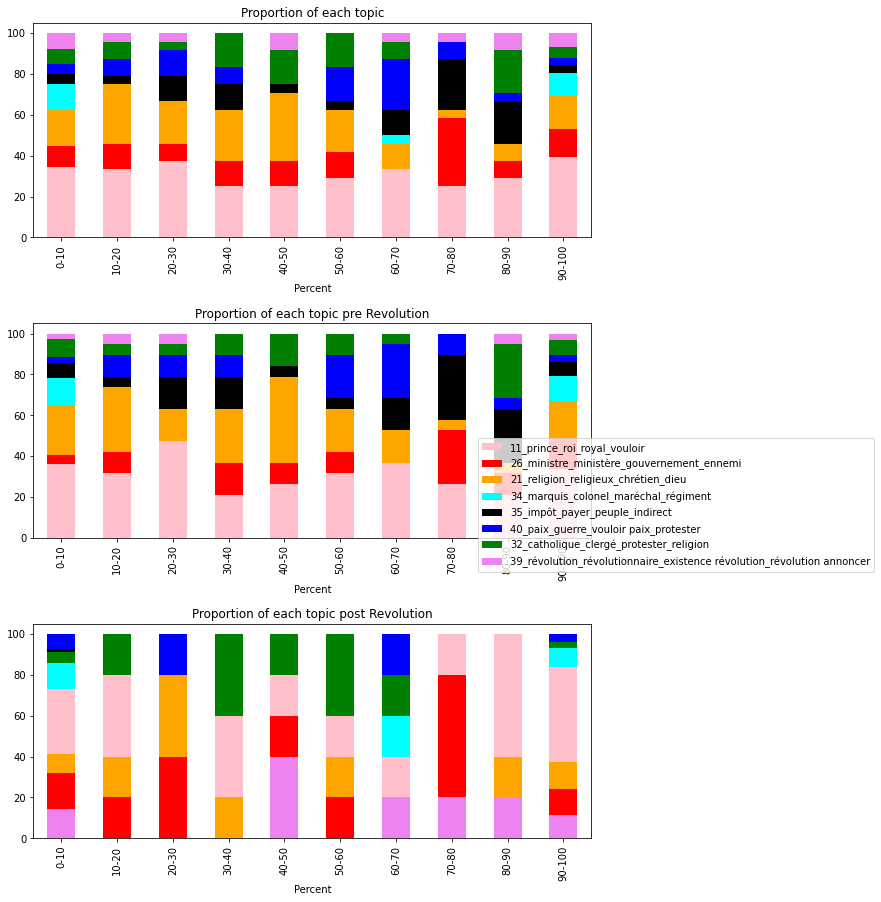

In [232]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = True)

Les deux sujets les plus importants post rev sont hasard chancelier perdre occuper et ministre ainsi que roi

Plus réparti avant la révolution

Religion a une part plus improtante avant la révolution

144it [00:00, 24849.00it/s]
78it [00:00, 19756.97it/s]
66it [00:00, 20681.66it/s]


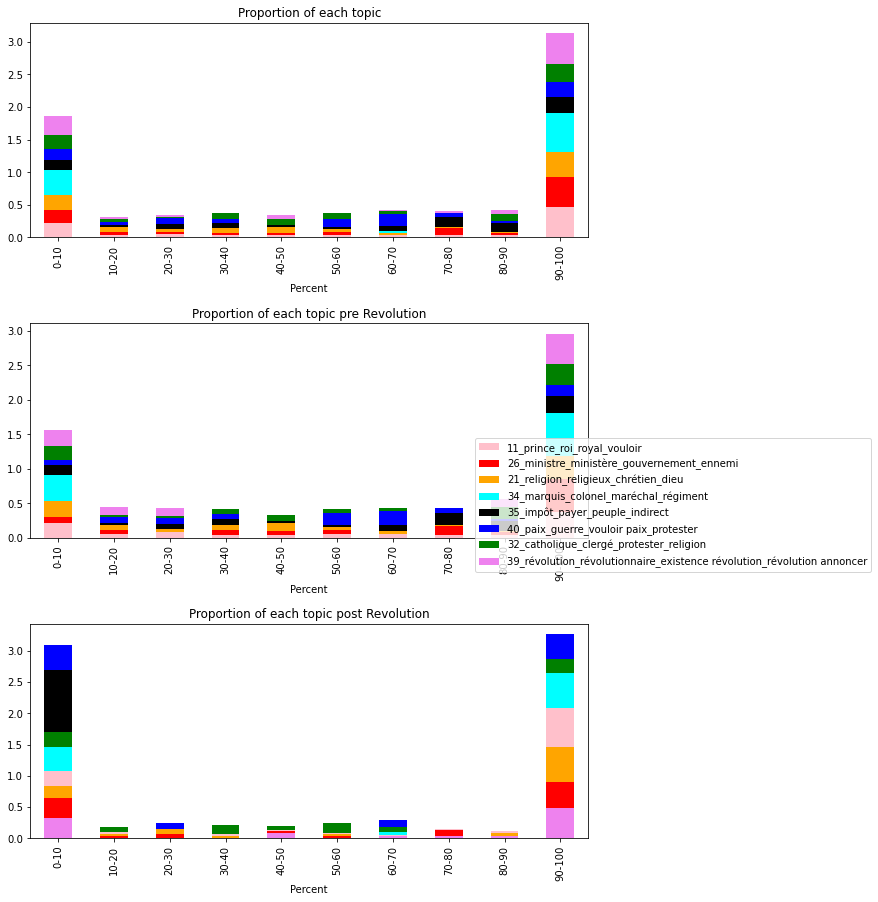

In [233]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Posterite

In [234]:
df_pos = df_sent_t.copy()
df_pos['Topic_Ordered'] = df_pos['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_posterite])

144it [00:00, 23959.85it/s]
78it [00:00, 21476.77it/s]
66it [00:00, 21490.88it/s]


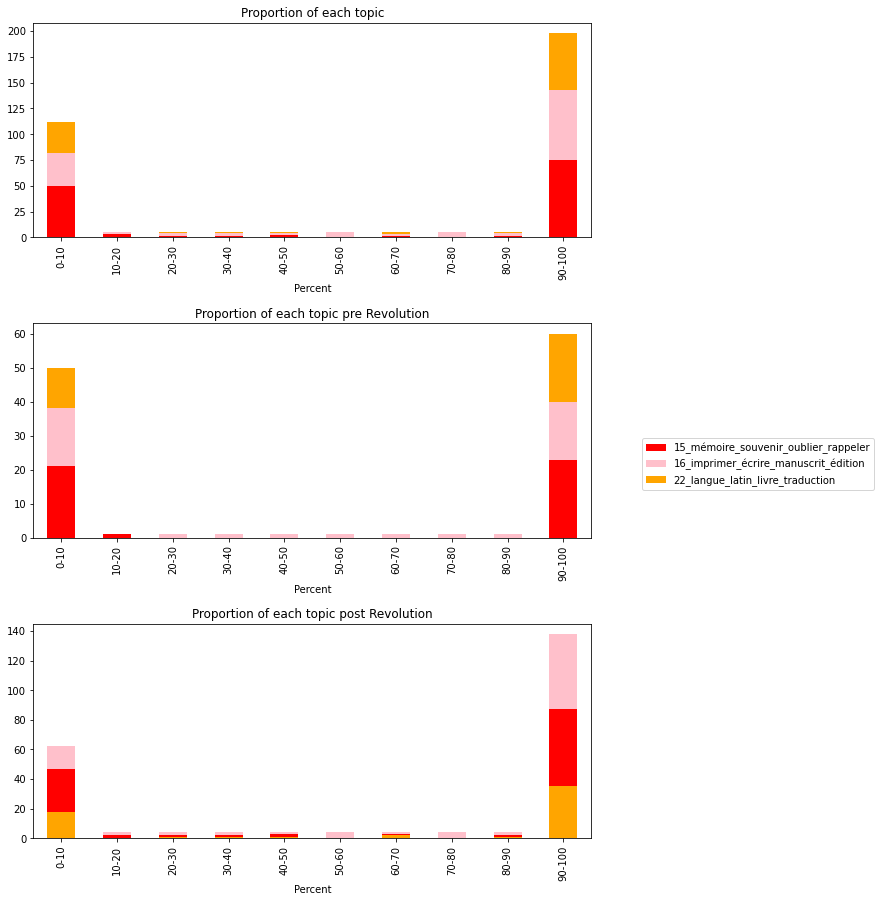

In [235]:
color_p = {'15_mémoire_souvenir_oublier_rappeler' : 'red', '16_imprimer_écrire_manuscrit_édition' : 'pink',
         '22_langue_latin_livre_traduction' : 'orange'}

_,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p)

Postérité beaucoup plus présente dans l'éloge après la Révolution

144it [00:00, 26534.57it/s]
78it [00:00, 22568.69it/s]
66it [00:00, 21774.88it/s]


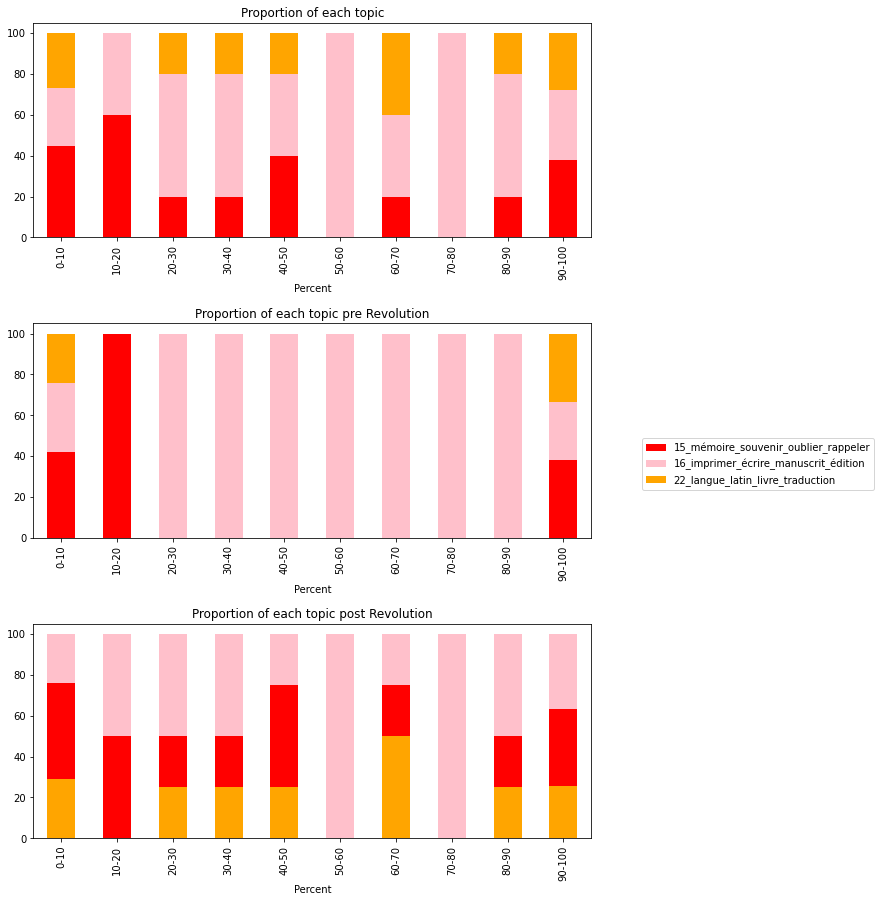

In [236]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm = True)

Avant la révolution postérité discutée qu'au début et à la fin de l'éloge par rapport à après la Révolution

144it [00:00, 22143.27it/s]
78it [00:00, 19477.03it/s]
66it [00:00, 14765.53it/s]


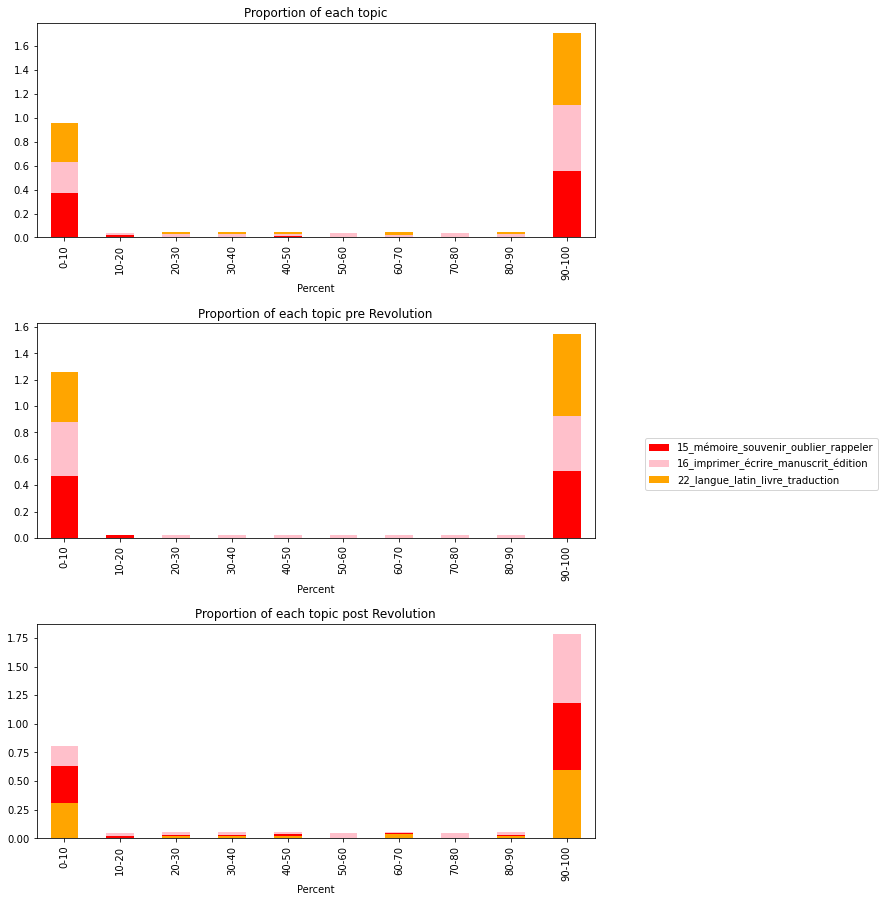

In [237]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Science

In [238]:
df_disc = df_sent_h.copy()
df_disc['Topic_Ordered'] = df_disc['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_science])

144it [00:00, 24750.23it/s]
78it [00:00, 22515.88it/s]
66it [00:00, 20426.81it/s]


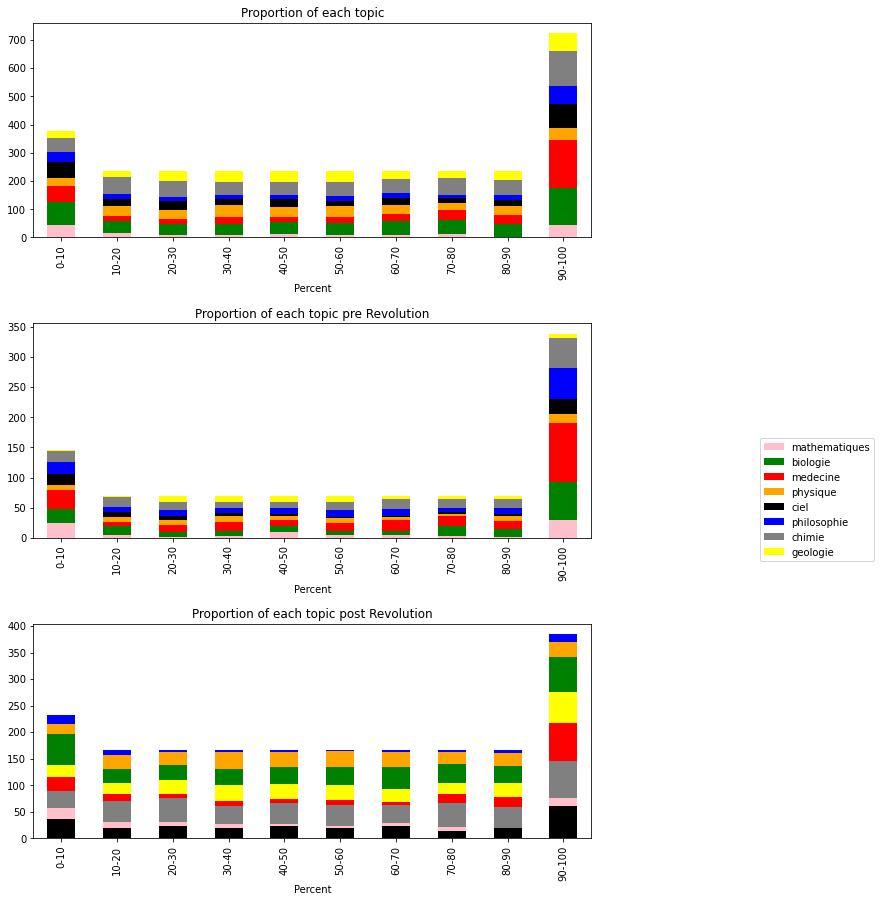

In [247]:
color_p = {'mathematiques'  : 'pink', 'medecine' : 'red', 'biologie' : 'green', 'philosophie' : 'blue',
          'ciel' : 'black', 'physique' :'orange', 'methode' : 'violet', 'chimie' :
          'grey', 'geologie' : 'yellow'}

#, '26_anatomie_anatomiste_histoire_comparer' : 'cyan', '13_pierre_montagne_rocher_volcan' :
#          'magenta', '18_rayon_lumière_rayer_raire' : 'brown', '27_esprit_âme_penser_idée' : 'beige',
 #         '23_expérience_confirmer_répéter_tenter' : 'gold', '2_planter_plante_espèce_jardin' : 'silver'
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

144it [00:00, 22995.61it/s]
78it [00:00, 19287.57it/s]
66it [00:00, 16378.18it/s]


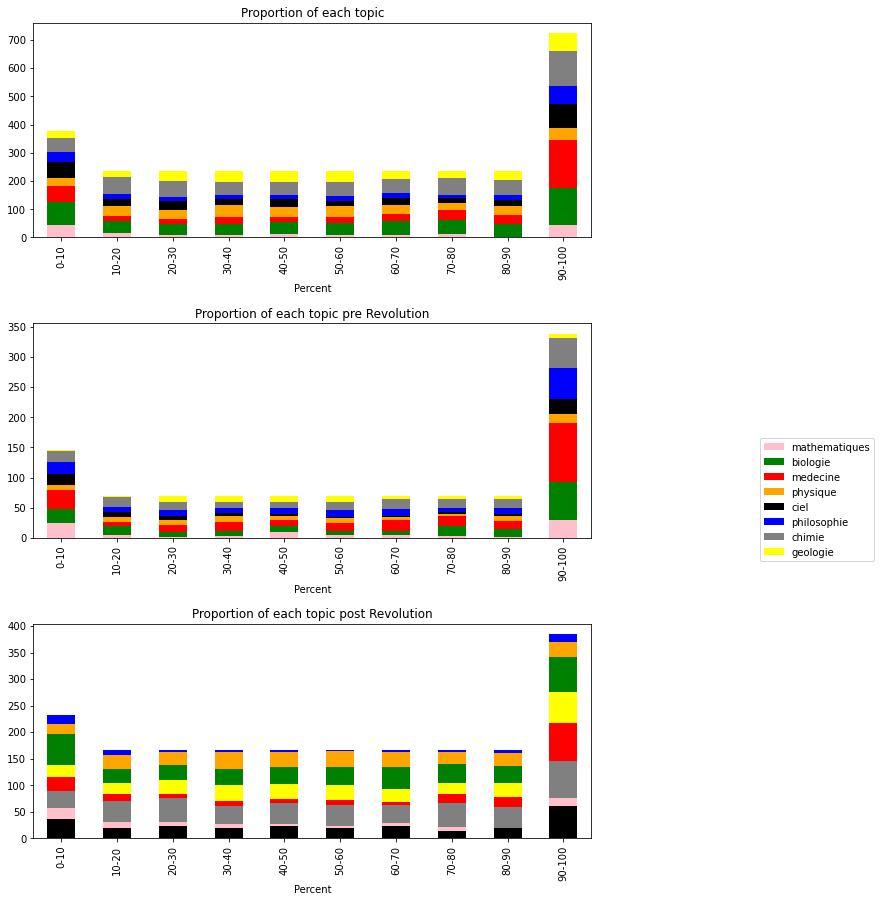

In [248]:
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

On parle plus de science dans le milieu du texte

On parle plus de l'art du dessin et de la peinture et philo en proportion

## Voyage

144it [00:00, 26676.37it/s]
78it [00:00, 24651.93it/s]
66it [00:00, 22673.77it/s]


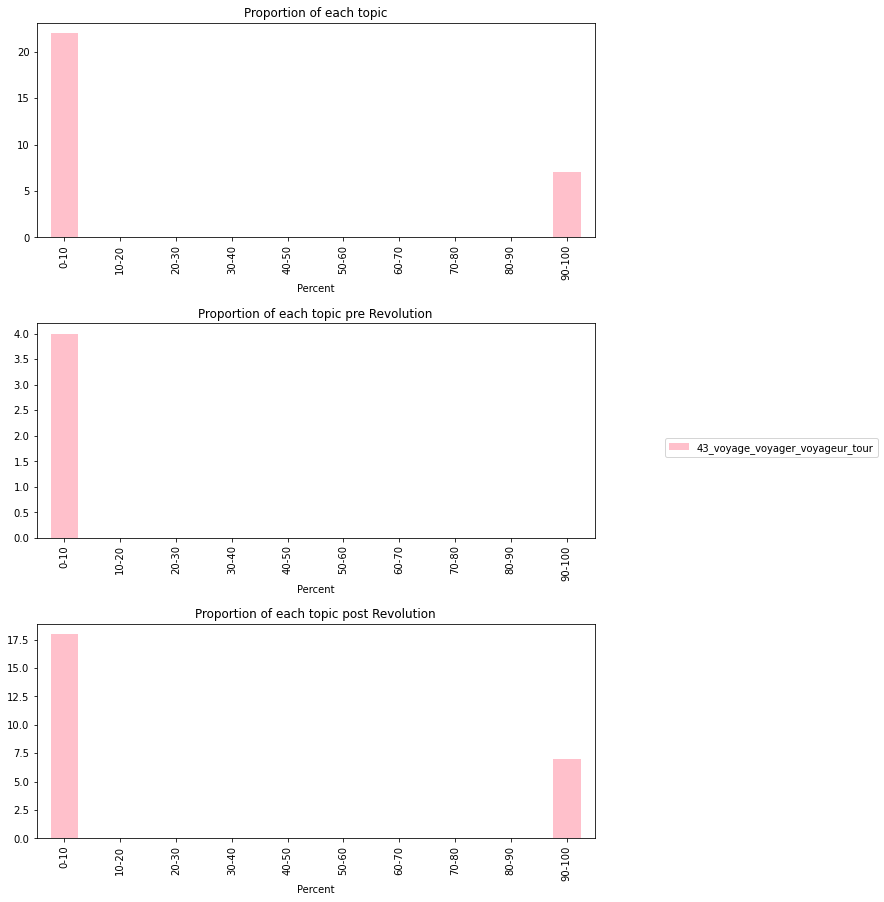

In [249]:
df_voy = df_sent_t.copy()
df_voy['Topic_Ordered'] = df_voy['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_voyage])

color_p = {'43_voyage_voyager_voyageur_tour'  : 'pink', '30_île_bougainville_visiter_côte' : 'red'}

perc,_,_ = plot_stack_bar(df_voy, keep_outliers = True, color_plot = color_p, norm = False)